# Customer Churn - C744 Perfomance Assessment

## Importing required libraries, Data Collection & Data Exploration

### 1. Importing Required Libraries

In [14]:
# Data processesing, CSV I/O 
import pandas as pd
import numpy as np

# Data Visualizations
import matplotlib as mt
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings

# Data Pre-processing, Model Building and Assessments
import sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn import under_sampling, over_sampling

from sklearn.ensemble import RandomForestClassifier

import statsmodels.api as sm # Stats model for ANOVA
import statsmodels.formula.api as smf 

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, roc_auc_score,roc_curve, precision_recall_curve

# For Tree visualization
from sklearn import tree
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import display

%matplotlib inline

### 2. Data Collection

In [15]:
# Notebook settings
pd.set_option('display.max_columns', 999)
pd.set_option("display.max_rows", 100)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [111]:
telecom = pd.read_csv("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv")
telecom.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed check           56.95       1889.5   
2              Yes               Mailed check           53.85       108.15   
3               No  Bank transfer (automatic)           42.30      1840.75   
4              Yes           Electronic check           70.70       151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

In [53]:

# Get the overview of data
telecom.info() 

## Obs: 
##  1. Out of all features, tenure, MonthlyCharges and TotalCharges looks like continuous variables. 
##        Need to explore more to decide type (categorical vs numerical) of each feature
##   1.1. Object type of TotalCharges is object. Need to change type to float for proper processing. 
##   1.2. SeniorCitizen is int64, but is a categorical feature (confirmed later by unique values)
##  2. 7043 observations and 21 features
##   2.1. 20 features (Predictor Variables) and 1 Dependent/Response variable - Churn -> 
##           since we need to predict finally if the customer would be retained or Churned based on features
## Need to check the individual statistics of the features and response variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [112]:
# Convert the type of TotalCharges & check for Missing Values
telecom["TotalCharges"] = telecom["TotalCharges"].apply(pd.to_numeric, downcast="float", errors="coerce")
telecom.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [55]:
telecom[telecom["TotalCharges"].isnull()]

customerID  gender  SeniorCitizen Partner Dependents  tenure  \
488   4472-LVYGI  Female              0     Yes        Yes       0   
753   3115-CZMZD    Male              0      No        Yes       0   
936   5709-LVOEQ  Female              0     Yes        Yes       0   
1082  4367-NUYAO    Male              0     Yes        Yes       0   
1340  1371-DWPAZ  Female              0     Yes        Yes       0   
3331  7644-OMVMY    Male              0     Yes        Yes       0   
3826  3213-VVOLG    Male              0     Yes        Yes       0   
4380  2520-SGTTA  Female              0     Yes        Yes       0   
5218  2923-ARZLG    Male              0     Yes        Yes       0   
6670  4075-WKNIU  Female              0     Yes        Yes       0   
6754  2775-SEFEE    Male              0      No        Yes       0   

     PhoneService     MultipleLines InternetService       OnlineSecurity  \
488            No  No phone service             DSL                  Yes   
753           Yes                No              No  No internet service   
936           Yes                No             DSL                  Yes   
1082          Yes               Yes              No  No internet service   
1340           No  No phone service             DSL                  Yes   
3331          Yes                No              No  No internet service   
3826          Yes               Yes              No  No internet service   
4380          Yes                No              No  No internet service   
5218          Yes                No              No  No internet service   
6670          Yes               Yes             DSL                   No   
6754          Yes               Yes             DSL                  Yes   

             OnlineBackup     DeviceProtection          TechSupport  \
488                    No                  Yes                  Yes   
753   No internet service  No internet service  No internet service   
936                   Yes                  Yes                   No   
1082  No internet service  No internet service  No internet service   
1340                  Yes                  Yes                  Yes   
3331  No internet service  No internet service  No internet service   
3826  No internet service  No internet service  No internet service   
4380  No internet service  No internet service  No internet service   
5218  No internet service  No internet service  No internet service   
6670                  Yes                  Yes                  Yes   
6754                  Yes                   No                  Yes   

              StreamingTV      StreamingMovies  Contract PaperlessBilling  \
488                   Yes                   No  Two year              Yes   
753   No internet service  No internet service  Two year               No   
936                   Yes                  Yes  Two year               No   
1082  No internet service  No internet service  Two year               No   
1340                  Yes                   No  Two year               No   
3331  No internet service  No internet service  Two year               No   
3826  No internet service  No internet service  Two year               No   
4380  No internet service  No internet service  Two year               No   
5218  No internet service  No internet service  One year              Yes   
6670                  Yes                   No  Two year               No   
6754                   No                   No  Two year              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges Churn  
488   Bank transfer (automatic)           52.55           NaN    No  
753                Mailed check           20.25           NaN    No  
936                Mailed check           80.85           NaN    No  
1082               Mailed check           25.75           NaN    No  
1340    Credit card (automatic)           56.05           NaN    No  
3331               Mailed check           19.85       

In [59]:
telecom["TotalCharges"].median(), telecom["TotalCharges"].mean()

(1397.4750366210938, 2283.300441385536)

In [113]:
telecom["TotalCharges"] = telecom["TotalCharges"].fillna(telecom["MonthlyCharges"])
telecom[telecom["customerID"]=="4472-LVYGI"] # Check one sample record. 

customerID  gender  SeniorCitizen Partner Dependents  tenure  \
488  4472-LVYGI  Female              0     Yes        Yes       0   

    PhoneService     MultipleLines InternetService OnlineSecurity  \
488           No  No phone service             DSL            Yes   

    OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies  \
488           No              Yes         Yes         Yes              No   

     Contract PaperlessBilling              PaymentMethod  MonthlyCharges  \
488  Two year              Yes  Bank transfer (automatic)           52.55   

     TotalCharges Churn  
488         52.55    No

In [114]:
telecom["SeniorCitizen"] = telecom.SeniorCitizen.astype("str")

In [115]:
telecom.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [37]:
# List number of unique entries in each of the feature
telecom.nunique()

## Obs: It is confirmed that tenure, MonthlyCharges and TotalCharges are numeric/continuous variables
##      The customerID feature is an identifier columns for each observation, with unique value for each observation.
##      Remaining 17 variables are categorical in nature.

gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
PhoneService           2
MultipleLines          2
InternetService        3
OnlineSecurity         2
OnlineBackup           2
DeviceProtection       2
TechSupport            2
StreamingTV            2
StreamingMovies        2
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
tenuregroup            5
dtype: int64

In [46]:
# List unique entries in each of the features
telecom_columns = telecom.columns.tolist()
telecom_columns

for i in telecom_columns:
    print(i, ": ", telecom[i].unique())

customerID :  ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender :  ['Female' 'Male']
SeniorCitizen :  ['0' '1']
Partner :  ['Yes' 'No']
Dependents :  ['No' 'Yes']
tenure :  [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService :  ['No' 'Yes']
MultipleLines :  ['No phone service' 'No' 'Yes']
InternetService :  ['DSL' 'Fiber optic' 'No']
OnlineSecurity :  ['No' 'Yes' 'No internet service']
OnlineBackup :  ['Yes' 'No' 'No internet service']
DeviceProtection :  ['No' 'Yes' 'No internet service']
TechSupport :  ['No' 'Yes' 'No internet service']
StreamingTV :  ['No' 'Yes' 'No internet service']
StreamingMovies :  ['No' 'Yes' 'No internet service']
Contract :  ['Month-to-month' 'One year' 'Two year']
PaperlessBilling :  ['Yes' 'No']
PaymentMethod :  ['Electronic check' '

## Feature Engineering
##### Obs: Some categorical levels can be condensed to reduced the # of levels. e.g OnlineSecurity => No internet service - > can be converted to No

In [116]:
# Some categorical feature levels can be refined for a cleaner classification between catergory levels

# 1. Change "No internet service" to "No"
l_reduce_nointernet = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", \
             "StreamingTV", "StreamingMovies"]

for cols in l_reduce_nointernet:
    telecom[cols] = telecom[cols].replace({"No internet service" : "No"})

# 2. Change "No phone service" to "No"
telecom["MultipleLines"] = telecom["MultipleLines"].replace({"No phone service": "No"})

# 3. Shorten PaymentMethod details
telecom["PaymentMethod"] = telecom["PaymentMethod"].replace({"Electronic check": "ECheck",
                                                             "Mailed check":"MCheck",
                                                             "Bank transfer (automatic)":"AutoBankTransfer",
                                                             "Credit card (automatic)":"AutoCreditCard"})

# 4. Shorten InternetService details
telecom["InternetService"] = telecom["InternetService"].replace({"Fiber optic" :"FiberOptic"})

#5. Shorten Contract details
telecom["Contract"] = telecom["Contract"].replace({"Month-to-month" :"Monthly", "One year":"1yr", "Two year":"2yr"})

In [117]:
# Convert Tenure into categorical feature levels
def tenure_conversion(df):
    if df["tenure"] <= 12:
        return "t_0_1"
    if (df["tenure"] > 12) & (df["tenure"] <= 24):
        return "t_1_2"
    if (df["tenure"] > 24) & (df["tenure"] <= 48):
        return "t_2_4"
    if (df["tenure"] > 48) & (df["tenure"] <= 60):
        return "t_4_5"
    if df["tenure"] > 60:
        return "t_5plus"
telecom["tenuregroup"] = telecom.apply(lambda x: tenure_conversion(x), axis=1)

In [118]:
# 1. Since converted to groups, tenure can be dropped
# 2. Since Customer ID is not adding any value to the analysis, it can be dropped 
telecom = telecom.drop(columns=["tenure", "customerID"],axis=1)

In [119]:
# Check the data set sample again after cleanzing and feature engineering.
telecom.head(5)

gender SeniorCitizen Partner Dependents PhoneService MultipleLines  \
0  Female             0     Yes         No           No            No   
1    Male             0      No         No          Yes            No   
2    Male             0      No         No          Yes            No   
3    Male             0      No         No           No            No   
4  Female             0      No         No          Yes            No   

  InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
0             DSL             No          Yes               No          No   
1             DSL            Yes           No              Yes          No   
2             DSL            Yes          Yes               No          No   
3             DSL            Yes           No              Yes         Yes   
4      FiberOptic             No           No               No          No   

  StreamingTV StreamingMovies Contract PaperlessBilling     PaymentMethod  \
0          No              No  Monthly              Yes            ECheck   
1          No              No      1yr               No            MCheck   
2          No              No  Monthly              Yes            MCheck   
3          No              No      1yr               No  AutoBankTransfer   
4          No              No  Monthly              Yes            ECheck   

   MonthlyCharges  TotalCharges Churn tenuregroup  
0           29.85     29.850000    No       t_0_1  
1           56.95   1889.500000    No       t_2_4  
2           53.85    108.150002   Yes       t_0_1  
3           42.30   1840.750000    No       t_2_4  
4           70.70    151.649994   Yes       t_0_1

In [120]:
# Check for Null values again to make sure all obersvations are okay
telecom.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
tenuregroup         0
dtype: int64

## Get Summary Statistics of the Data

In [31]:
telecom.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   PhoneService      7043 non-null   object 
 5   MultipleLines     7043 non-null   object 
 6   InternetService   7043 non-null   object 
 7   OnlineSecurity    7043 non-null   object 
 8   OnlineBackup      7043 non-null   object 
 9   DeviceProtection  7043 non-null   object 
 10  TechSupport       7043 non-null   object 
 11  StreamingTV       7043 non-null   object 
 12  StreamingMovies   7043 non-null   object 
 13  Contract          7043 non-null   object 
 14  PaperlessBilling  7043 non-null   object 
 15  PaymentMethod     7043 non-null   object 
 16  MonthlyCharges    7043 non-null   float64


In [70]:
#Get summary stats for all continious variables
telecom.describe() 

## Obs: 

MonthlyCharges  TotalCharges
count     7043.000000   7043.000000
mean        64.761692   2279.798992
std         30.090047   2266.730171
min         18.250000     18.799999
25%         35.500000    398.549988
50%         70.350000   1394.550049
75%         89.850000   3786.599976
max        118.750000   8684.799805

In [17]:
## Box-Plot to understand Outliers on continuous variables

# 1. Tenure
#telecom["tenure"].plot(kind="box", color = "r")

## Obs: No Outliers

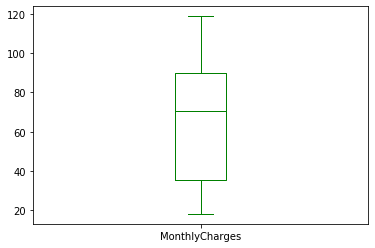

In [17]:
#1. MonthlyCharges
telecom["MonthlyCharges"].plot(kind="box", color = "g")

## Obs: No Outliers

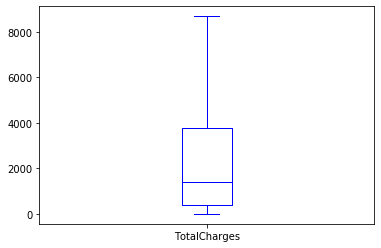

In [18]:
#2. TotalCharges
telecom["TotalCharges"].plot(kind="box", color = "b")

## Obs: No Outliers

## Check the summary & distribution of data

### Summary of Features & Response Variables

Percentage of Retained Customers: 73.46%
Percentage of Churn Customers: 26.54%


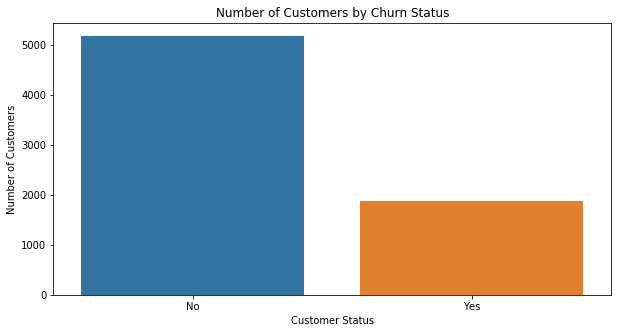

In [76]:
plt.figure(figsize=(10,5))
sns.countplot(data=telecom, x="Churn")
plt.xlabel("Customer Status")
plt.ylabel("Number of Customers")
plt.title("Number of Customers by Churn Status")

count_no = len(telecom[telecom["Churn"] == "No"])
count_yes = len(telecom[telecom["Churn"] == "Yes"])

print(f"Percentage of Retained Customers: {count_no/(count_no+count_yes) :.2%}")
print(f"Percentage of Churn Customers: {count_yes/(count_no+count_yes) :.2%}")

# looks like an imbalaced data set - Need to handle this future steps during model building

In [121]:
#split categorical, numerical features, excluding customerID and Target Variable

cat_columns = telecom.nunique()[telecom.nunique() < 6].keys().tolist()
cat_columns = [col for col in cat_columns if col not in ["Churn"]]

num_columns = [col for col in telecom.columns if col not in cat_columns + ["Churn"]]

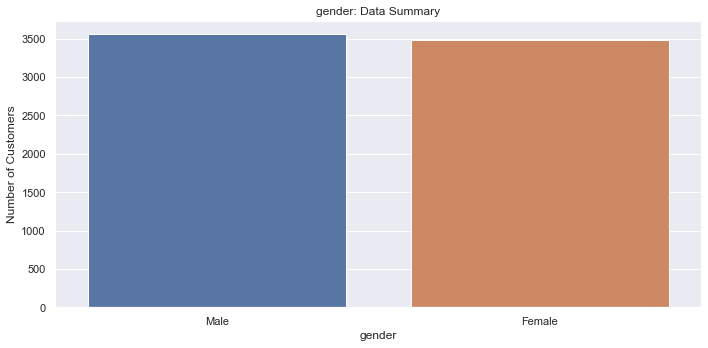

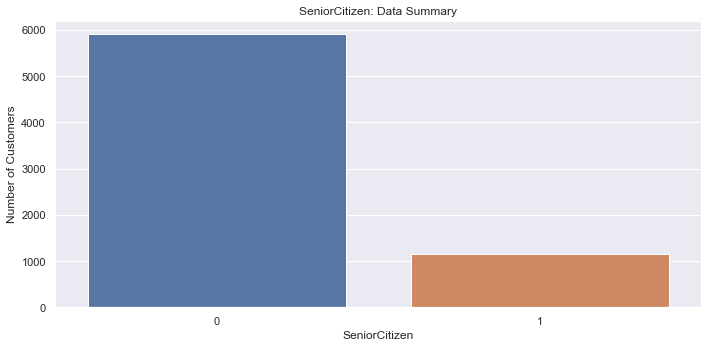

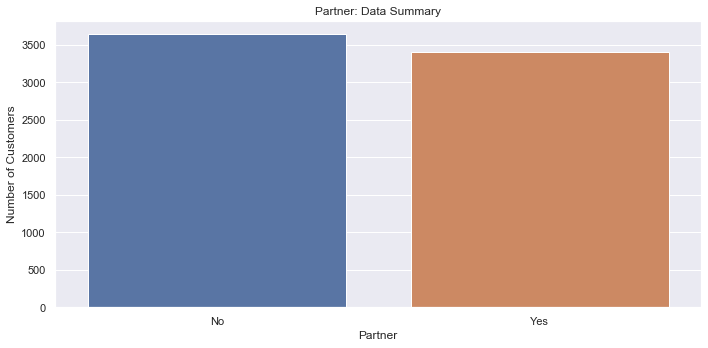

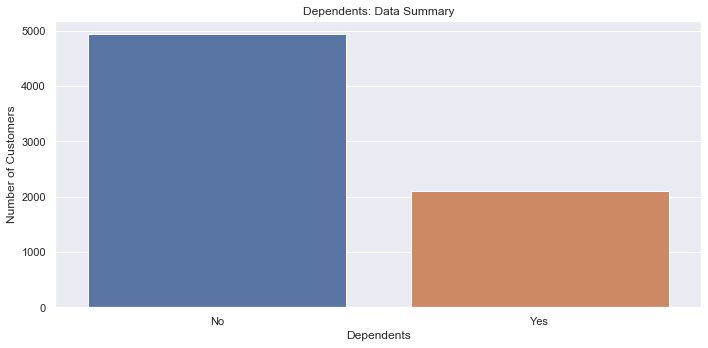

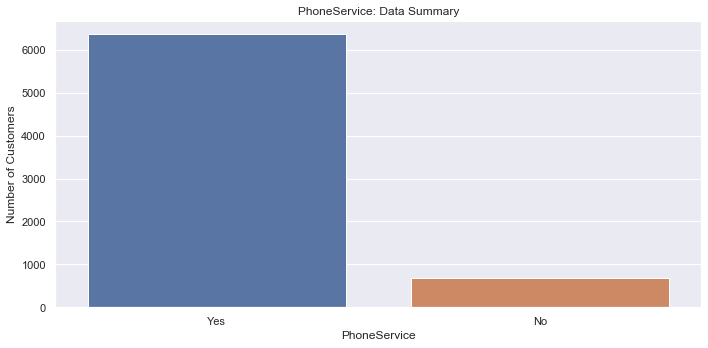

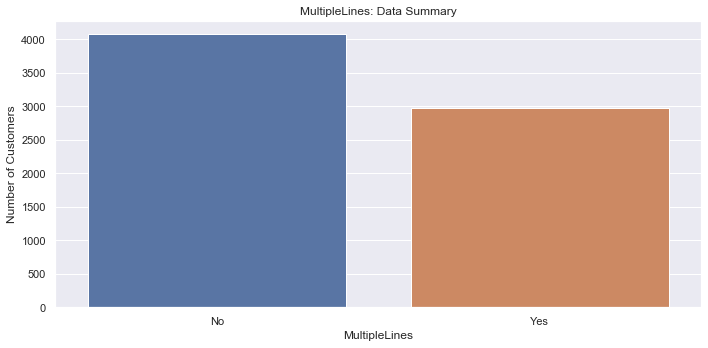

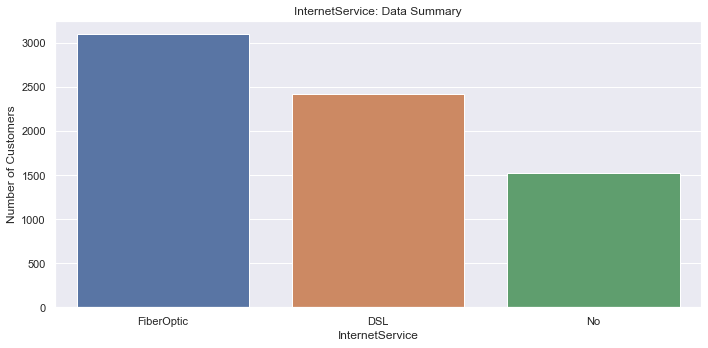

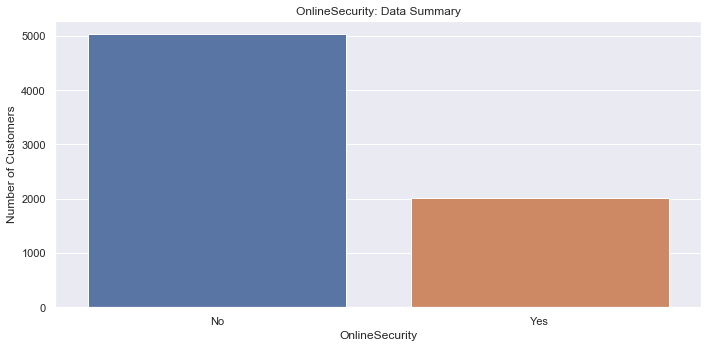

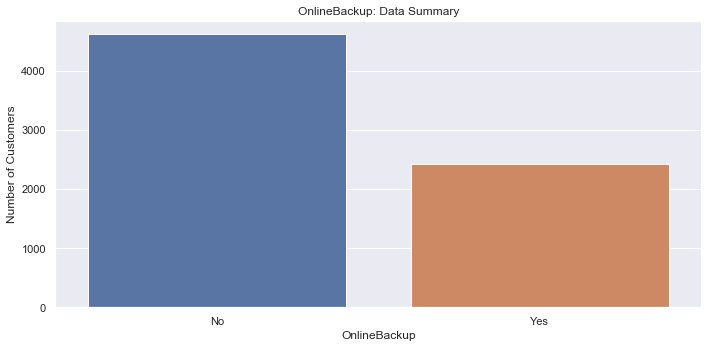

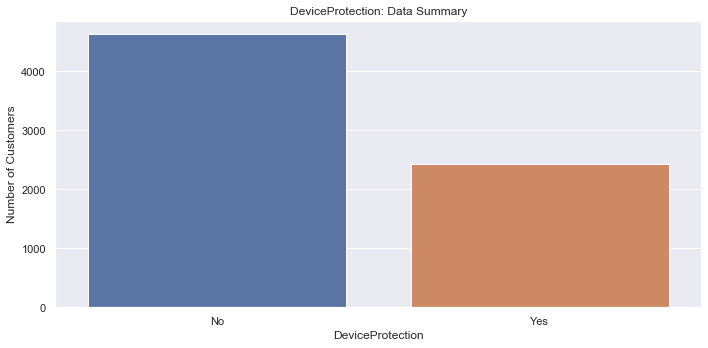

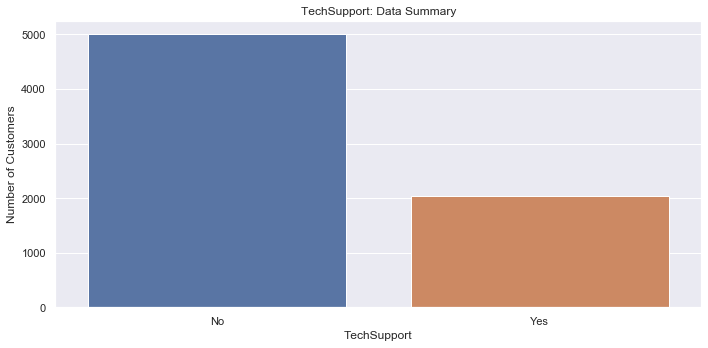

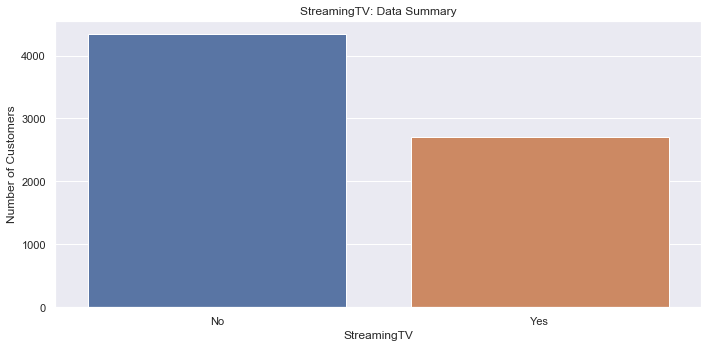

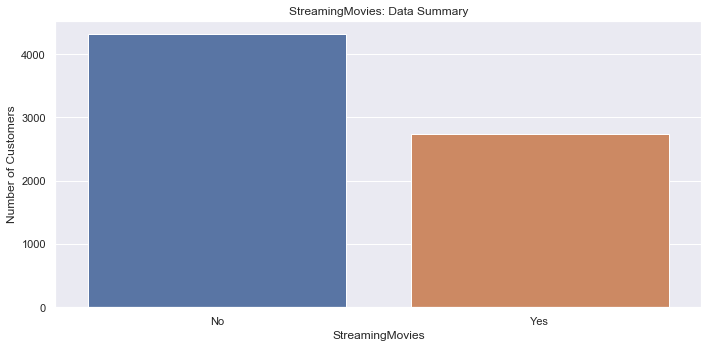

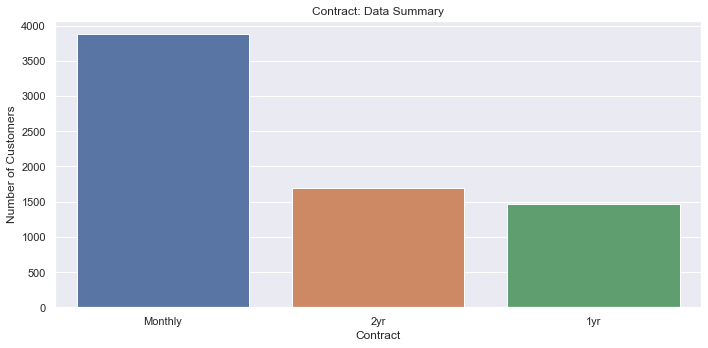

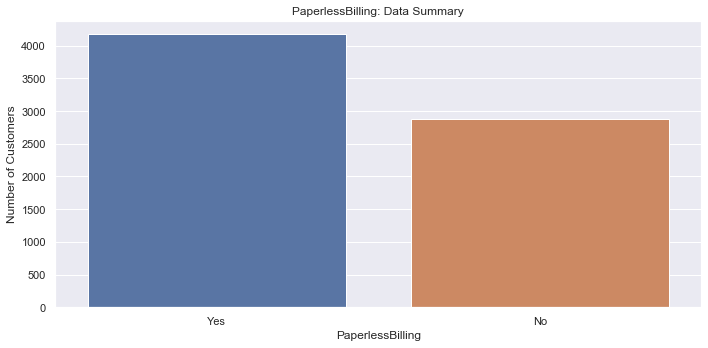

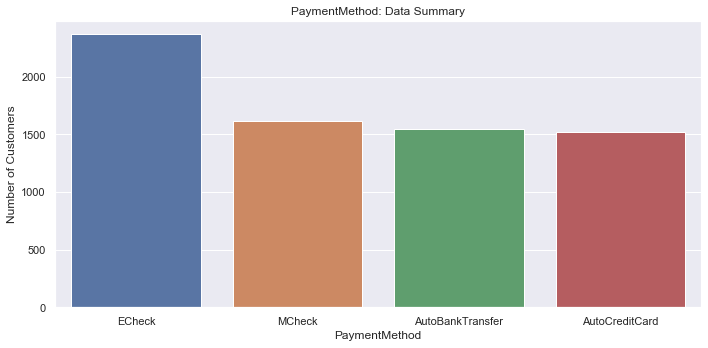

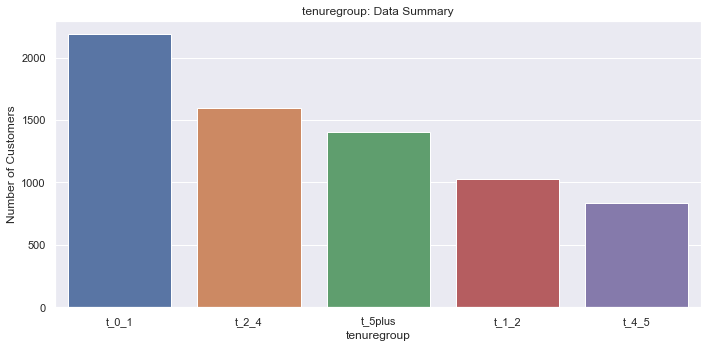

In [82]:
# Count Plot for all Categorical Features

fig,ax = plt.subplots(figsize=(5,7))
plt.close("all")
sns.set(font_scale=1)

for col in cat_columns:    
    #plt.figure(figsize=(10,5))
    plt.subplots(figsize=(10,5))       
    sns.countplot(x=col, data=telecom, order = telecom[col].value_counts().index).set_title(f"{col}: Data Summary")
    plt.xlabel(col)
    plt.ylabel("Number of Customers")
    plt.tight_layout()

# Will be plotted in Descending order of the value count by feature levels    

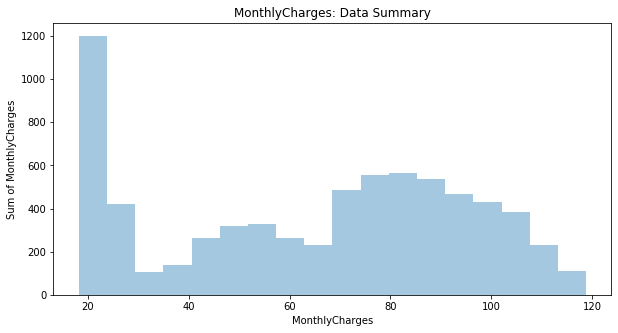

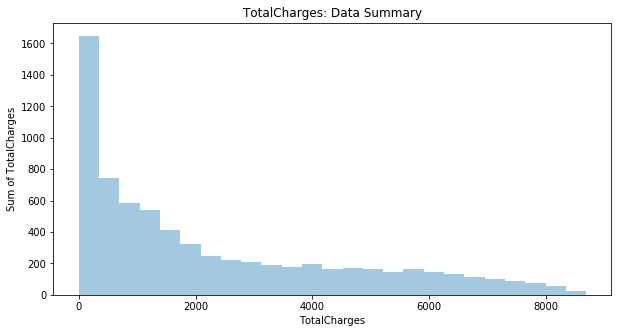

In [21]:
# Histogram and Density Plots for continuous features

#1. Histograms

for col in num_columns:    
    plt.figure(figsize=(10,5))    
    plt.tight_layout()
    sns.distplot(telecom[col], kde=False, hist=True).set_title(f"{col}: Data Summary")
    #plt.xlabel(col)
    plt.ylabel(f"Sum of {col}")

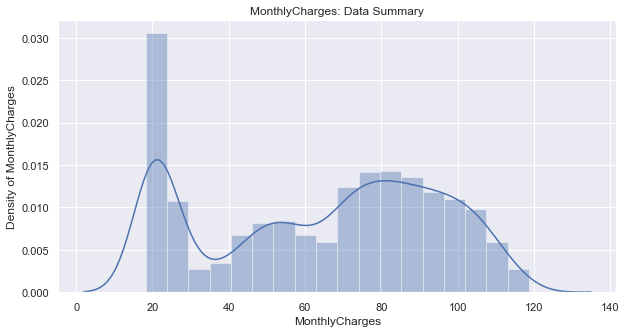

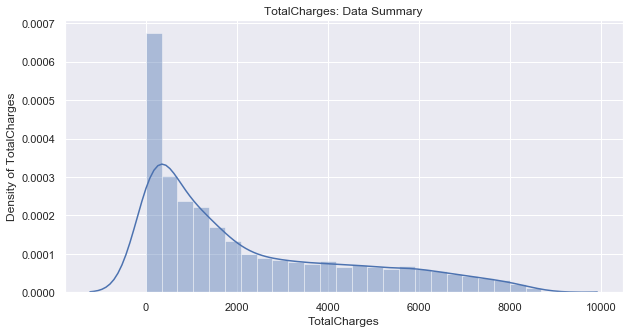

In [24]:
# 2. Density Plots

for col in num_columns:
    plt.figure(figsize=(10,5))    
    plt.tight_layout()
    sns.distplot(telecom[col], kde=True, hist=True).set_title(f"{col}: Data Summary")
    plt.ylabel(f"Density of {col}")

In [26]:
# Check Percentage of Retained vs Churned Customers from the Data Set
retain_count = len(telecom[telecom["Churn"]=="No"])
churn_count = len(telecom[telecom["Churn"]=="Yes"])

print(f"Percentage of Retained Customers is: {(retain_count/(retain_count+churn_count)) :0.2%}")
print(f"Percentage of Churned Customers is: {(churn_count/(retain_count+churn_count)) :0.2%}")

## Obs: Classes are imbalanced and the ratio of retain to churn is 73:26

Percentage of Retained Customers is: 73.46%
Percentage of Churned Customers is: 26.54%


In [27]:
## Check Means with respect to the Response variable
telecom.groupby("Churn").mean() #Ignore SeniorCitizen

#Obs: 
# 1. Avg. tenure for churn customer is lower than retained customers by 20 months
# 2. Avg. Monthly Charges for churned customer is higher than retained customers by 10.2
# 3. Avg. Total Charges for Churned customer is lower than retained customers by 1018.12 
#      => ties in since avg tenure for churn is lower

MonthlyCharges  TotalCharges
Churn                              
No          61.265124   2549.911443
Yes         74.441332   1531.796092

In [83]:
# Calculate average charges for each categorical variables 
for col in cat_columns:
    print(f"\033[1m {col} Avg: \033[0;0m\n {telecom.groupby(col).mean()} \n")

 gender Avg: 
         MonthlyCharges  TotalCharges
gender                              
Female       65.204243   2279.999142
Male         64.327482   2279.602615 

 SeniorCitizen Avg: 
                MonthlyCharges  TotalCharges
SeniorCitizen                              
0                   61.847441   2177.101009
1                   79.820359   2810.465195 

 Partner Avg: 
          MonthlyCharges  TotalCharges
Partner                              
No            61.945001   1584.112375
Yes           67.776264   3024.359538 

 Dependents Avg: 
             MonthlyCharges  TotalCharges
Dependents                              
No               67.002808   2187.709255
Yes              59.522156   2495.096943 

 PhoneService Avg: 
               MonthlyCharges  TotalCharges
PhoneService                              
No                 42.028592   1496.192888
Yes                67.199041   2363.813984 

 MultipleLines Avg: 
                MonthlyCharges  TotalCharges
MultipleLines      

## Visualizations - Feature by each Response Variable class

In [122]:
## Distribution of Frequency by each class of Response variable, for all Categorical Features

churn_customers = telecom[telecom["Churn"] == "Yes"]
nochurn_customers = telecom[telecom["Churn"] == "No"]

In [85]:
# Use Matplotlib to plot the pie and histogram (with overlay) graphs
# Display frequency of each of the categorical feature by Churn level

sns.set(font_scale=2)
colors = ["lightskyblue", "lightcoral", "royalblue", "red", "green","yellowgreen", "gold", ]
def category_plots(colname):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,12))
    churn_dist = ax1.pie(churn_customers[colname].value_counts().values.tolist(), \
                         autopct = "%1.1f%%", \
                         startangle = 90, \
                         labels = churn_customers[colname].unique().tolist(), \
                         textprops={'size': 'small'}, colors = colors)

    nochurn_dist = ax2.pie(nochurn_customers[colname].value_counts().values.tolist(), \
                           autopct = "%1.1f%%", startangle = 90, \
                           labels = nochurn_customers[colname].unique().tolist(), \
                           textprops={'size': 'small'}, colors = colors)

    fig.suptitle(f"{colname} Churn vs Retention Distribution", verticalalignment = "baseline")
    fig = plt.gcf()

    ax1.set_title("Churned Customers", fontdict = {'verticalalignment': "top"}, loc = "center", pad = -10)
    ax2.set_title("Retained Customers", fontdict = {'verticalalignment': "top"}, loc = "center", pad = -10)

    plt.tight_layout()
    plt.show()

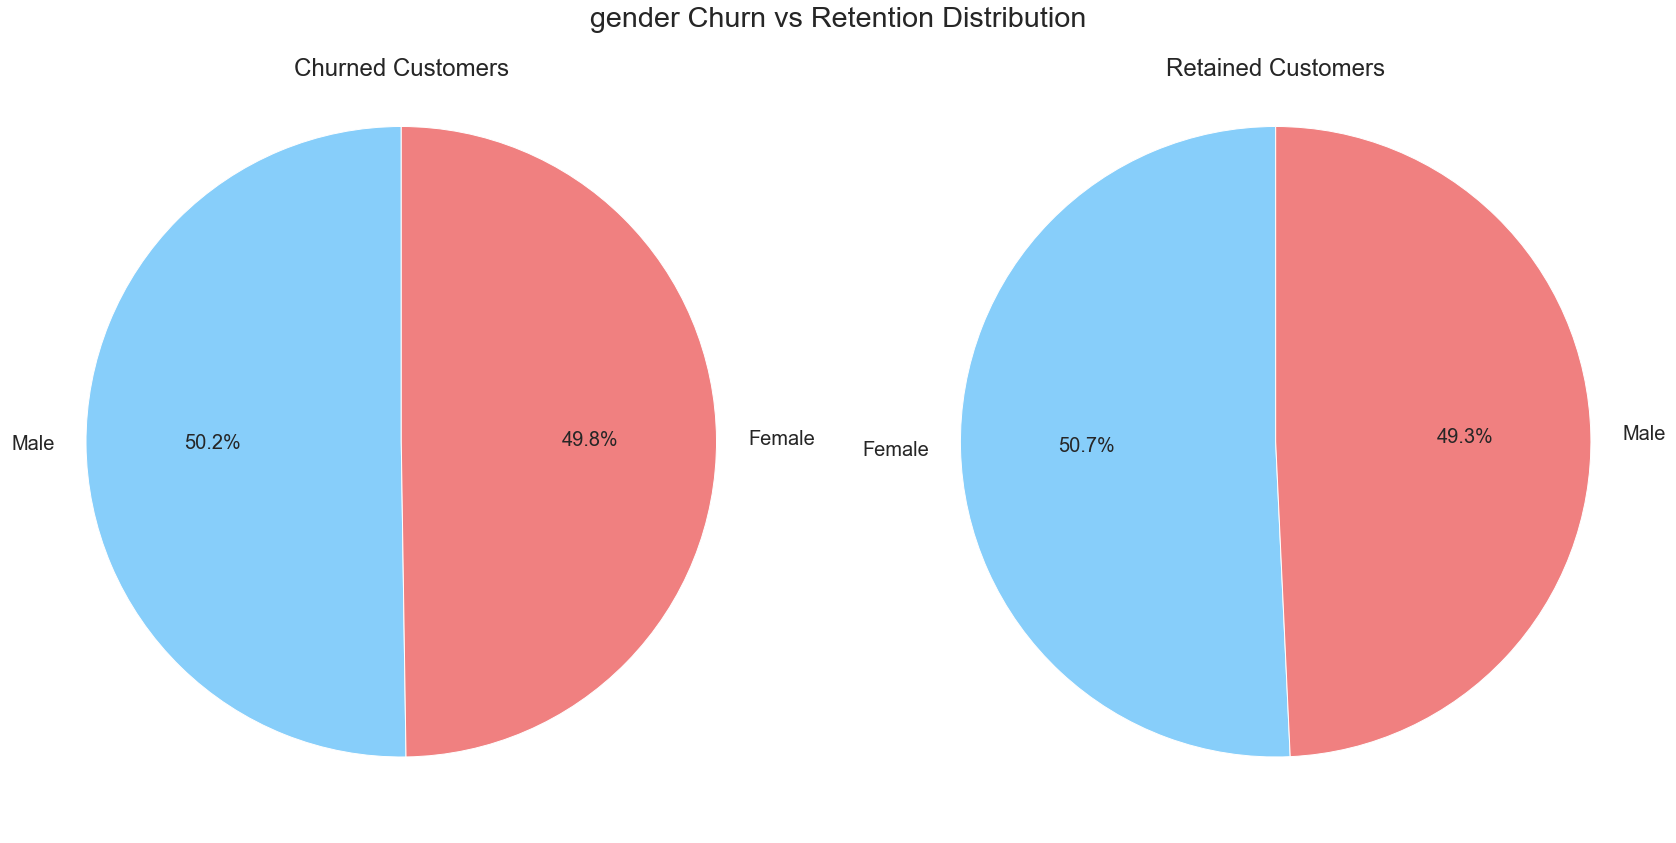

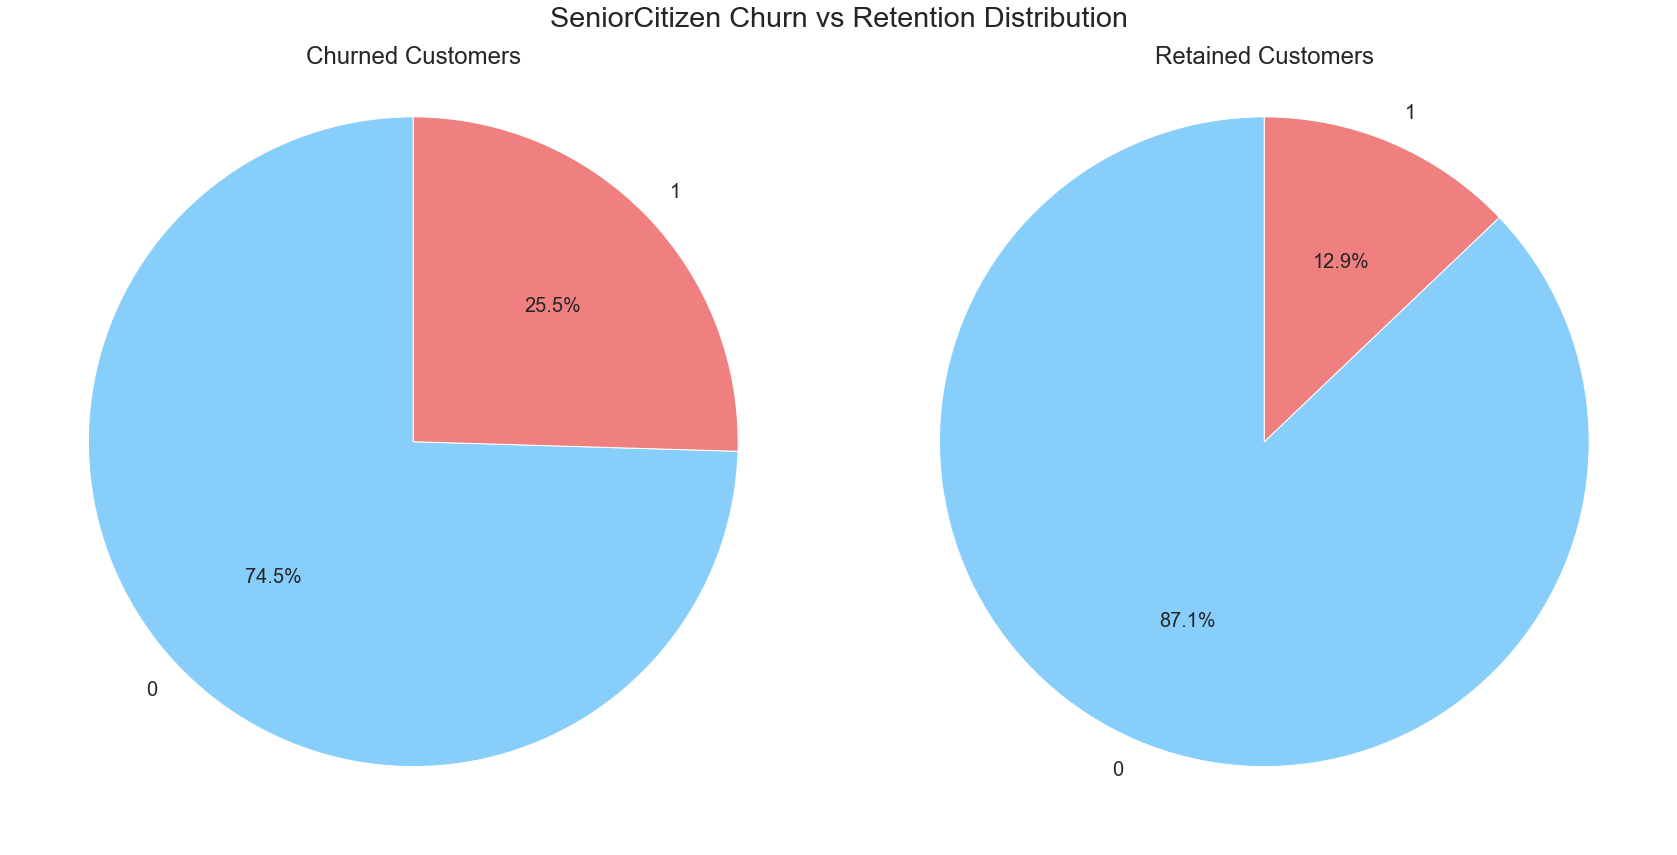

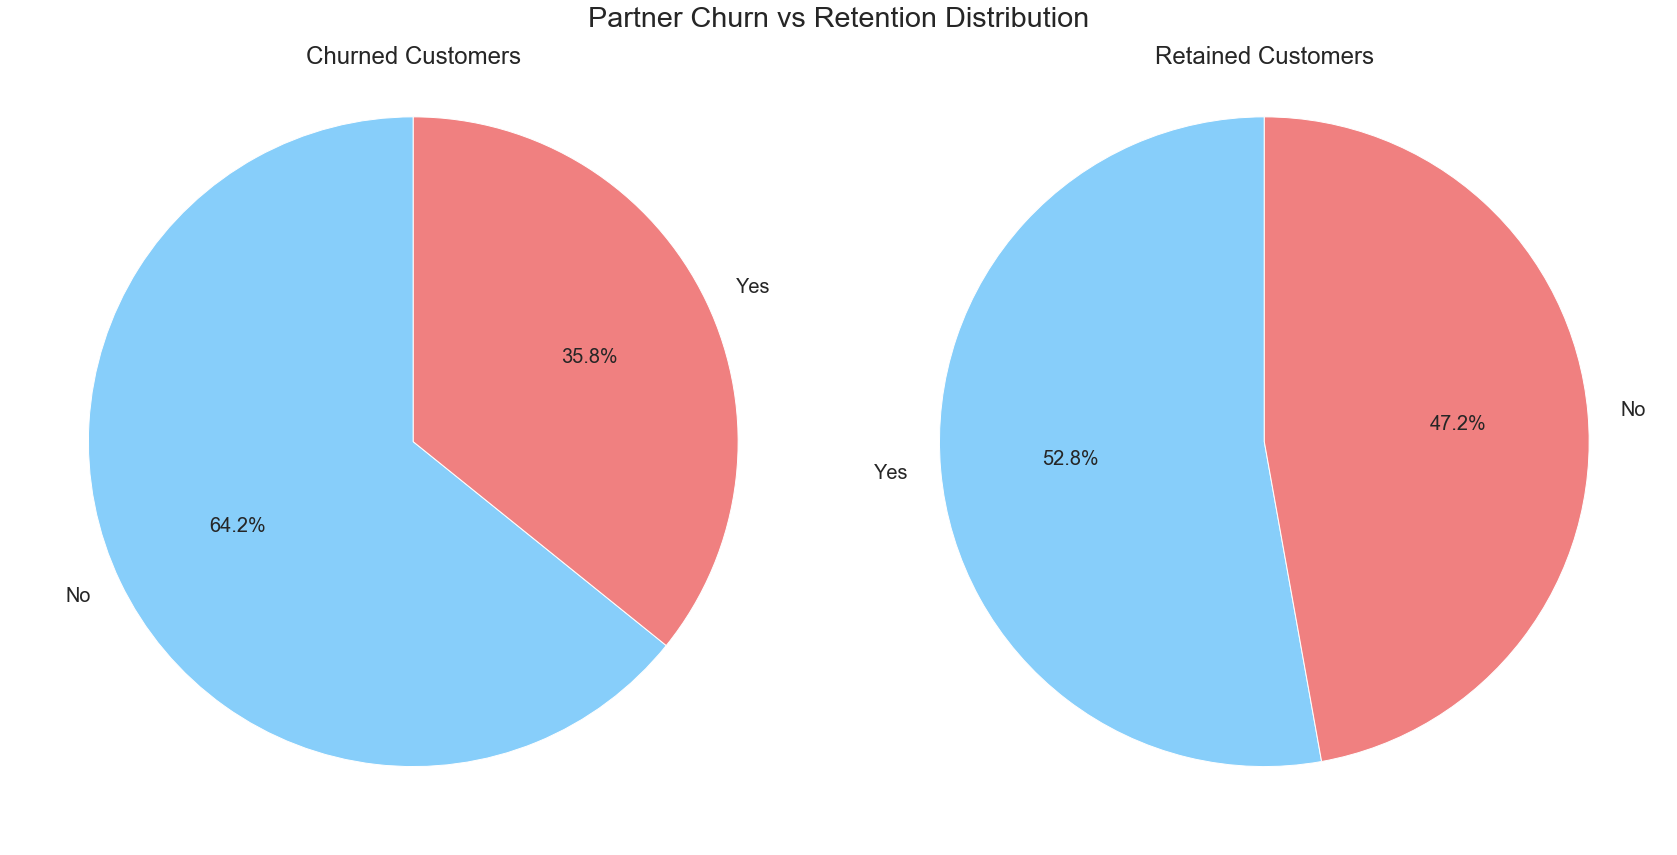

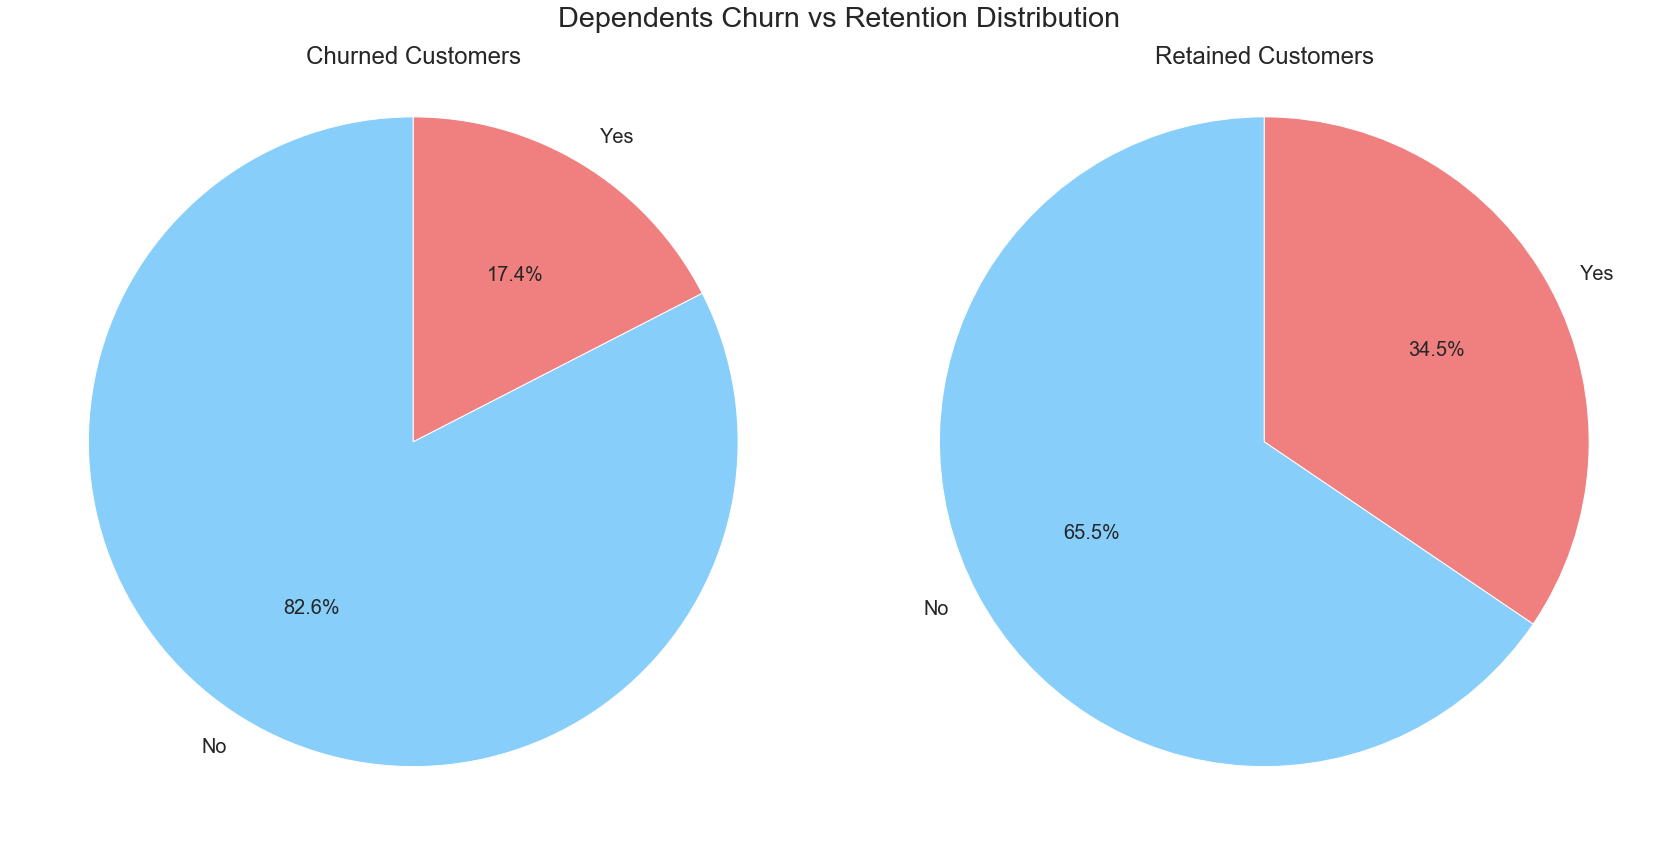

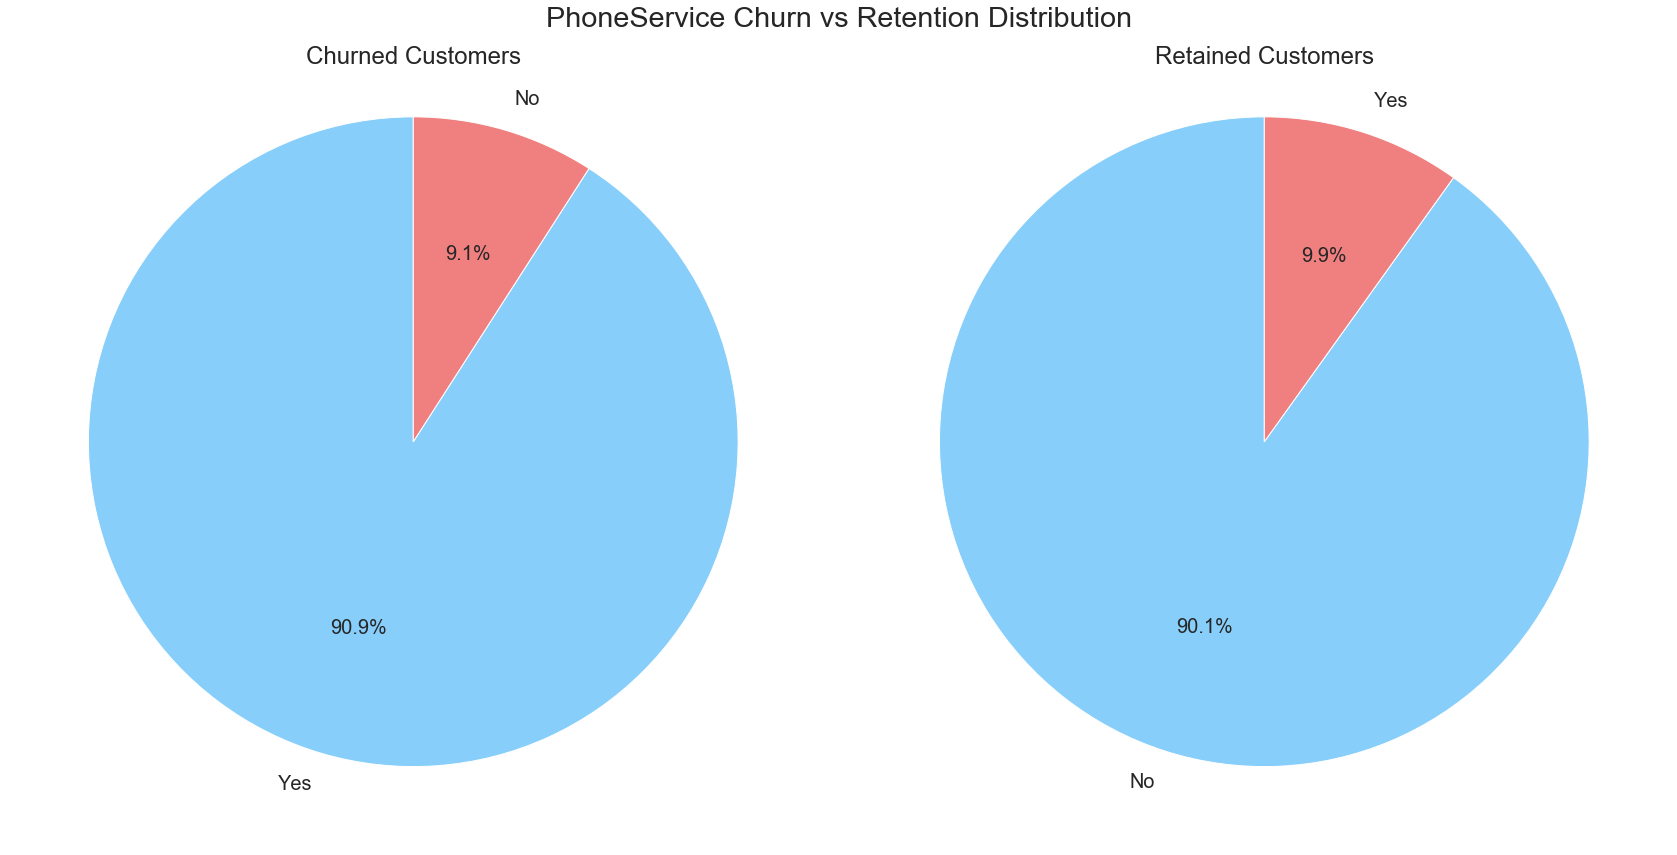

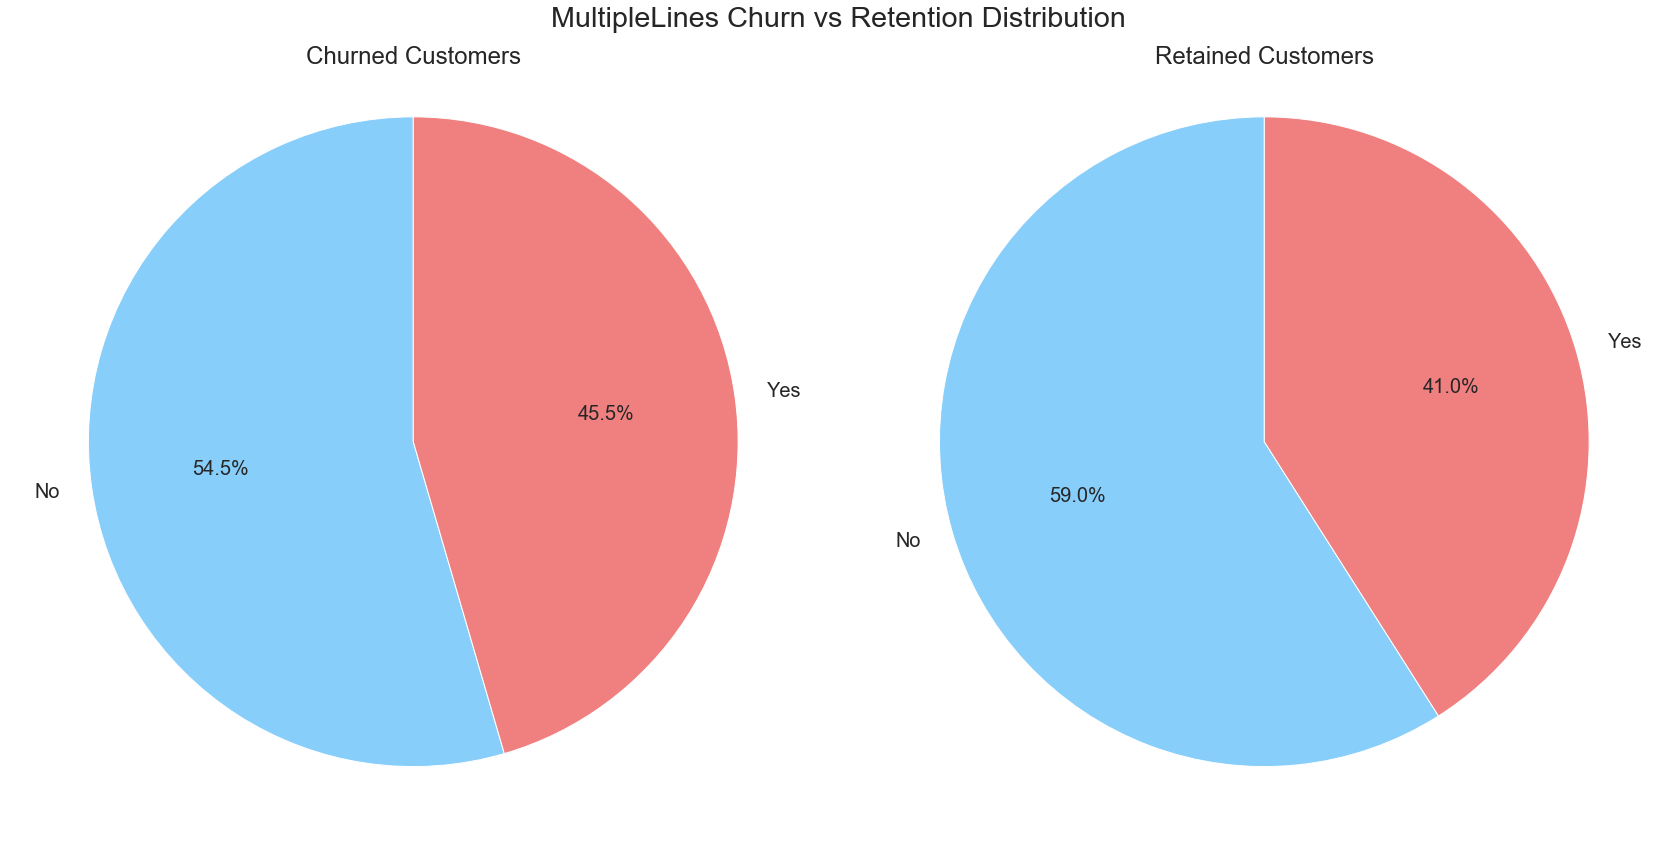

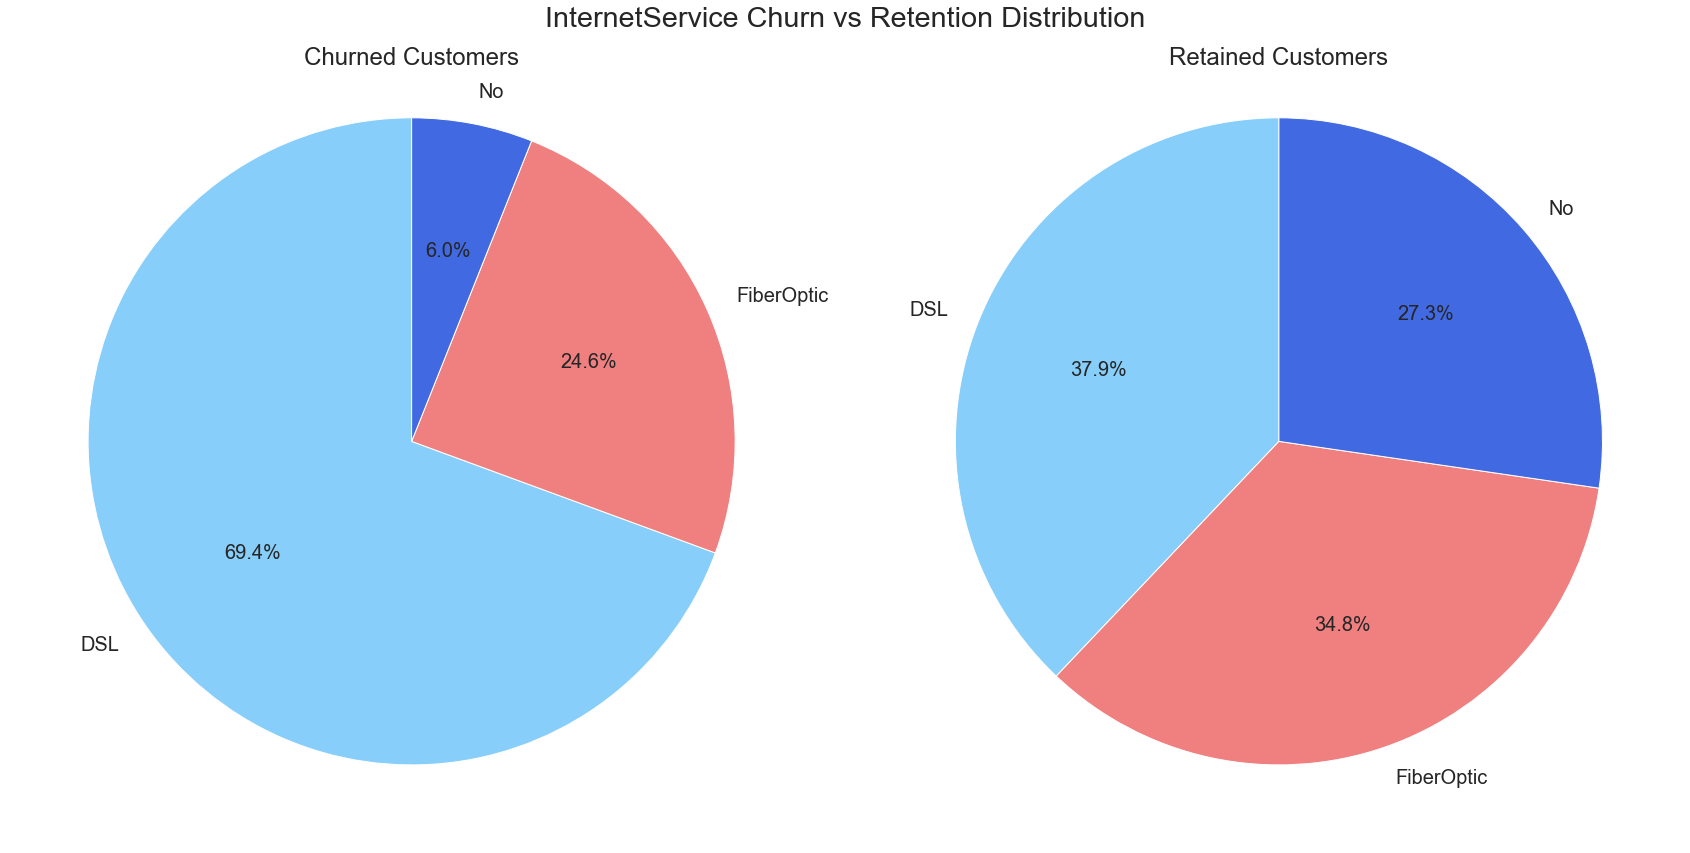

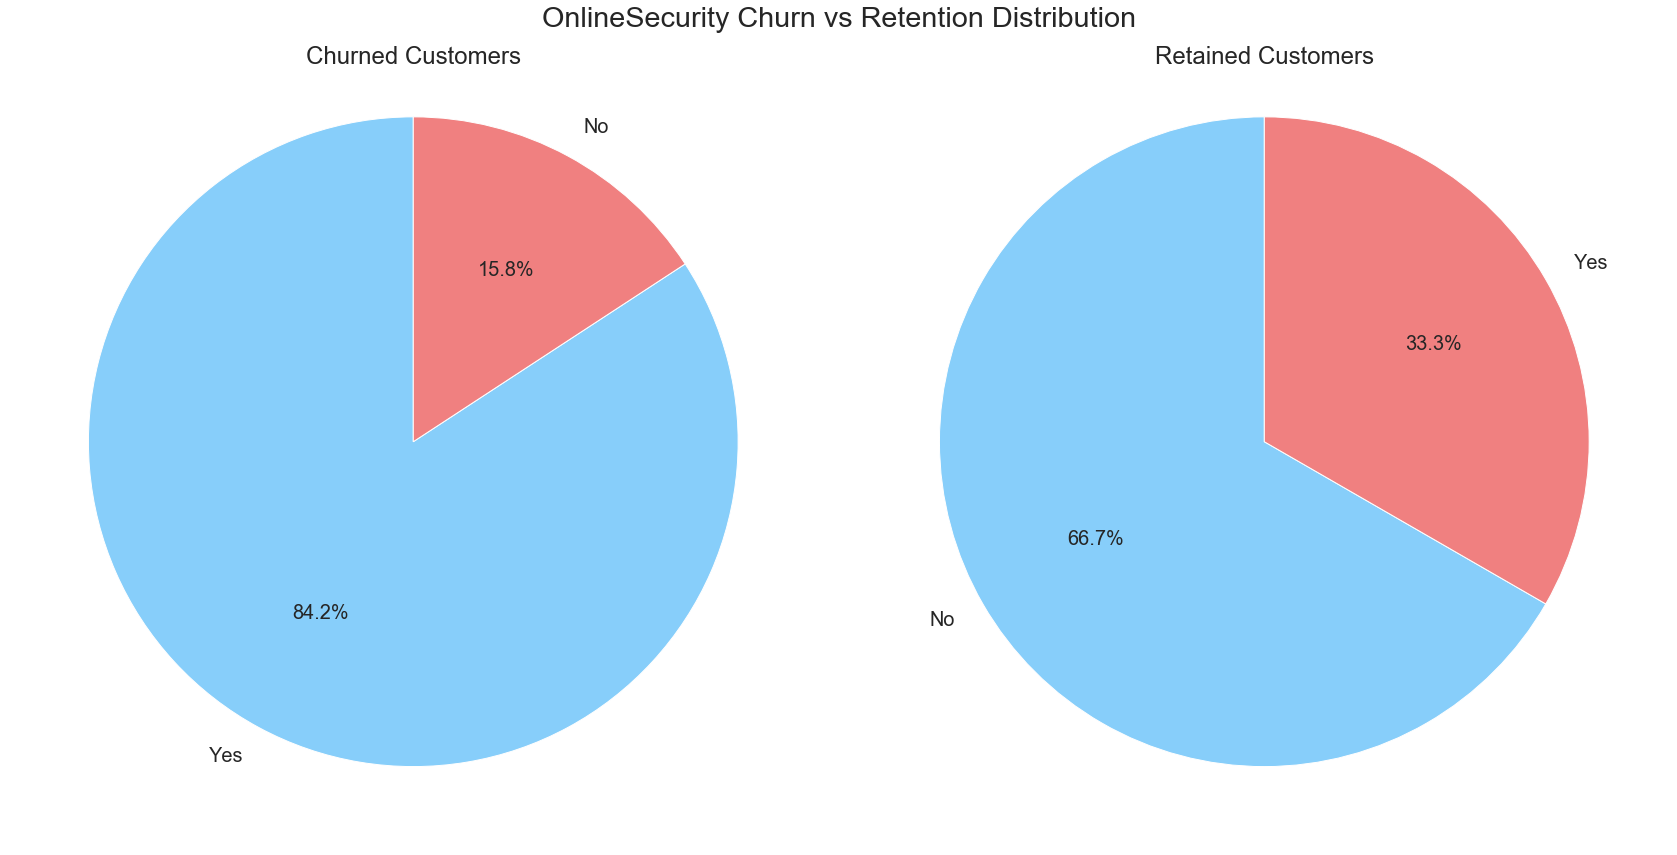

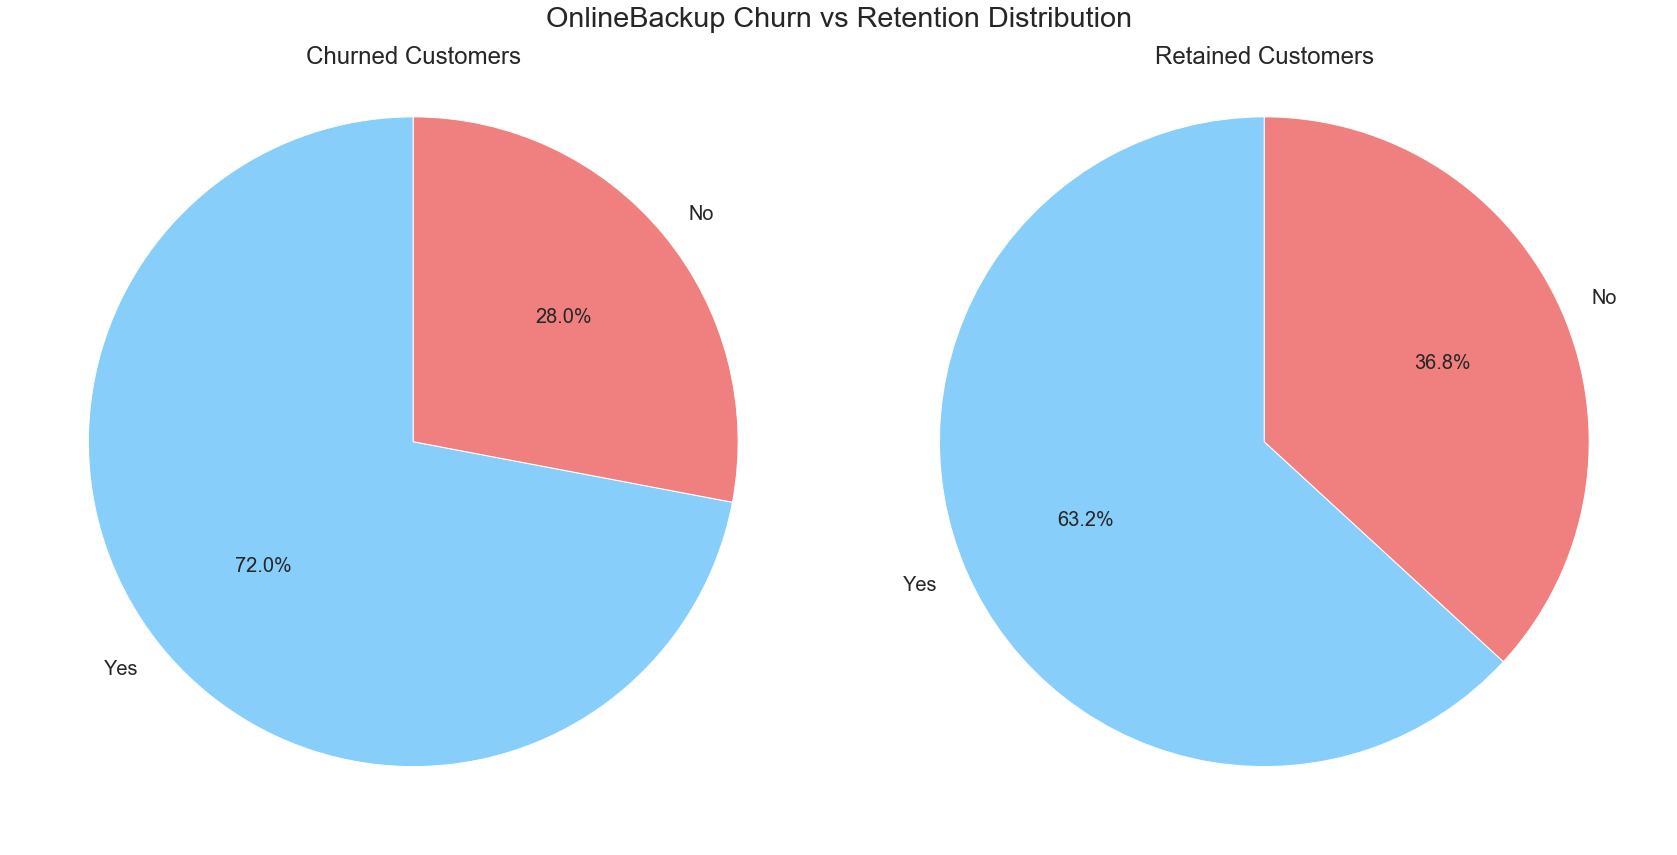

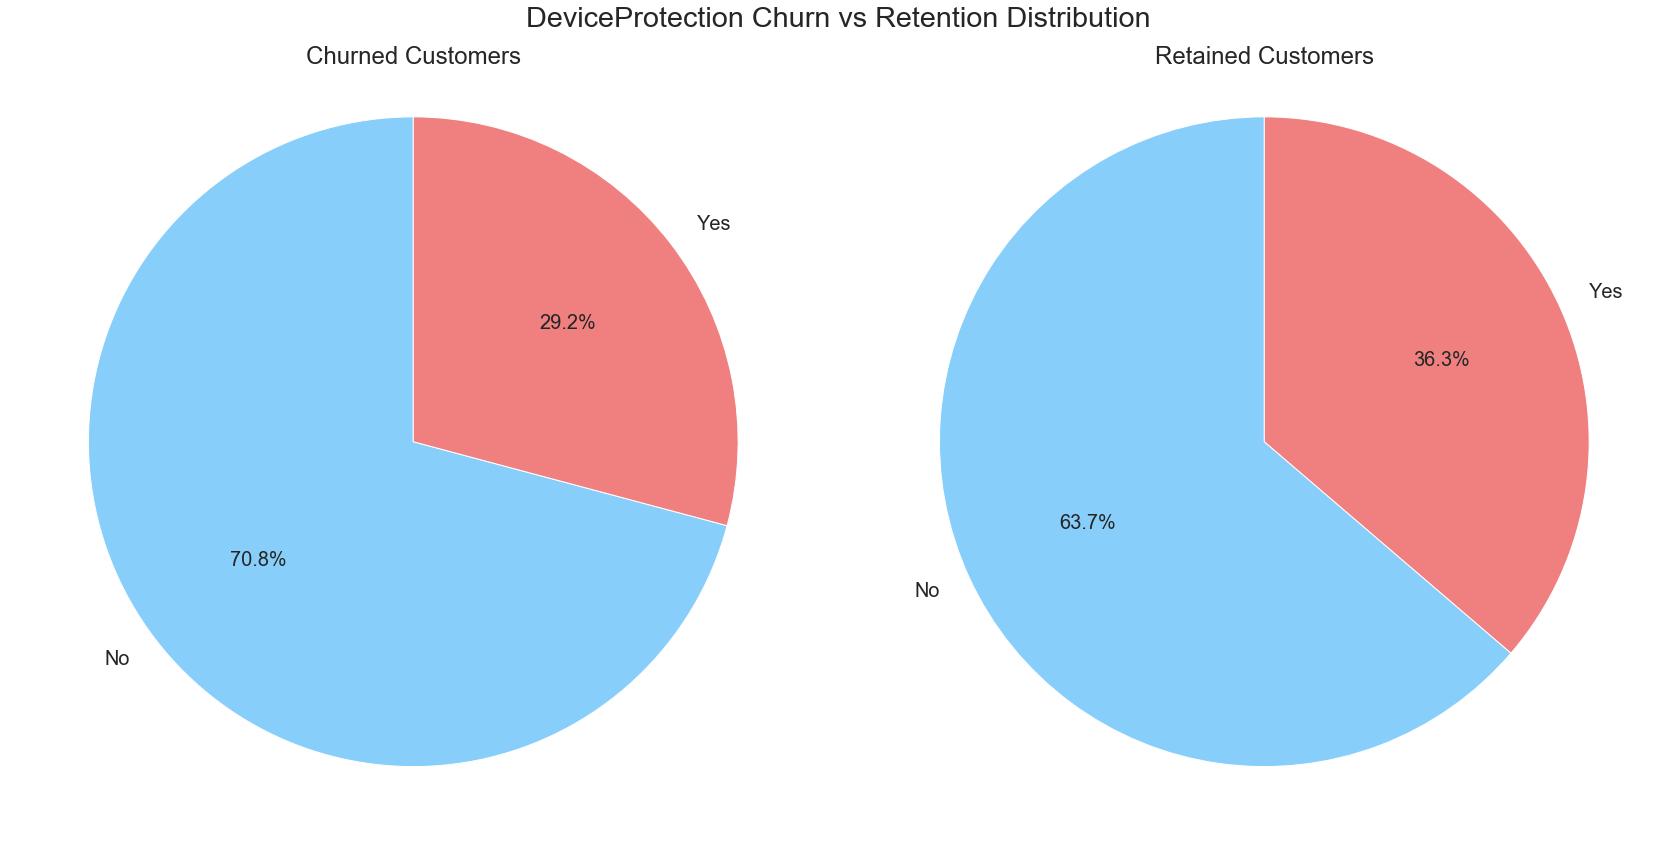

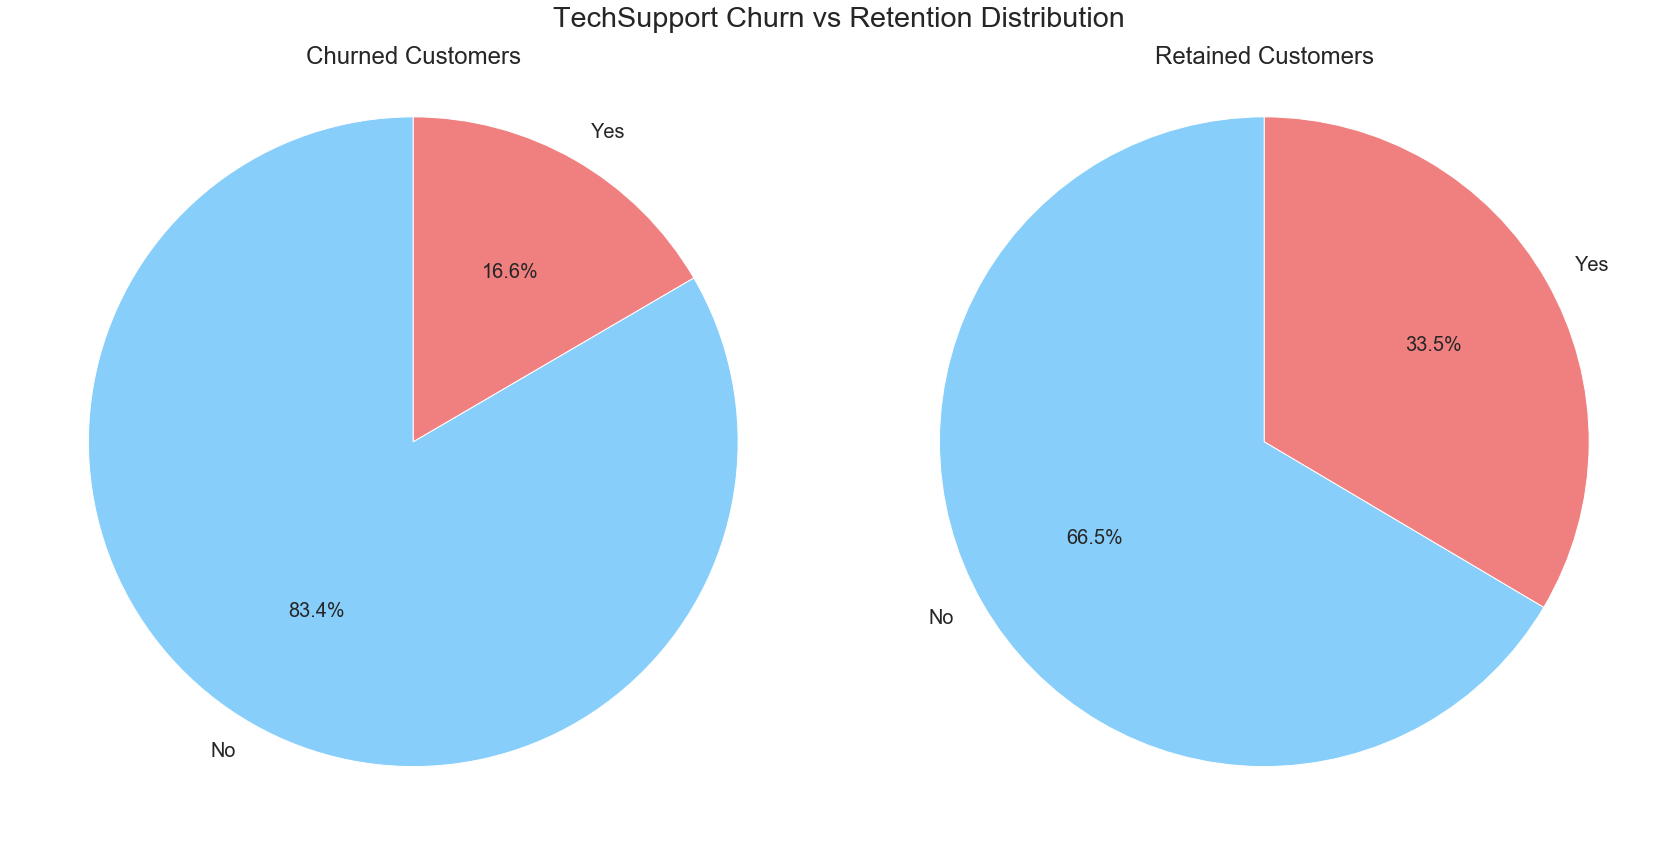

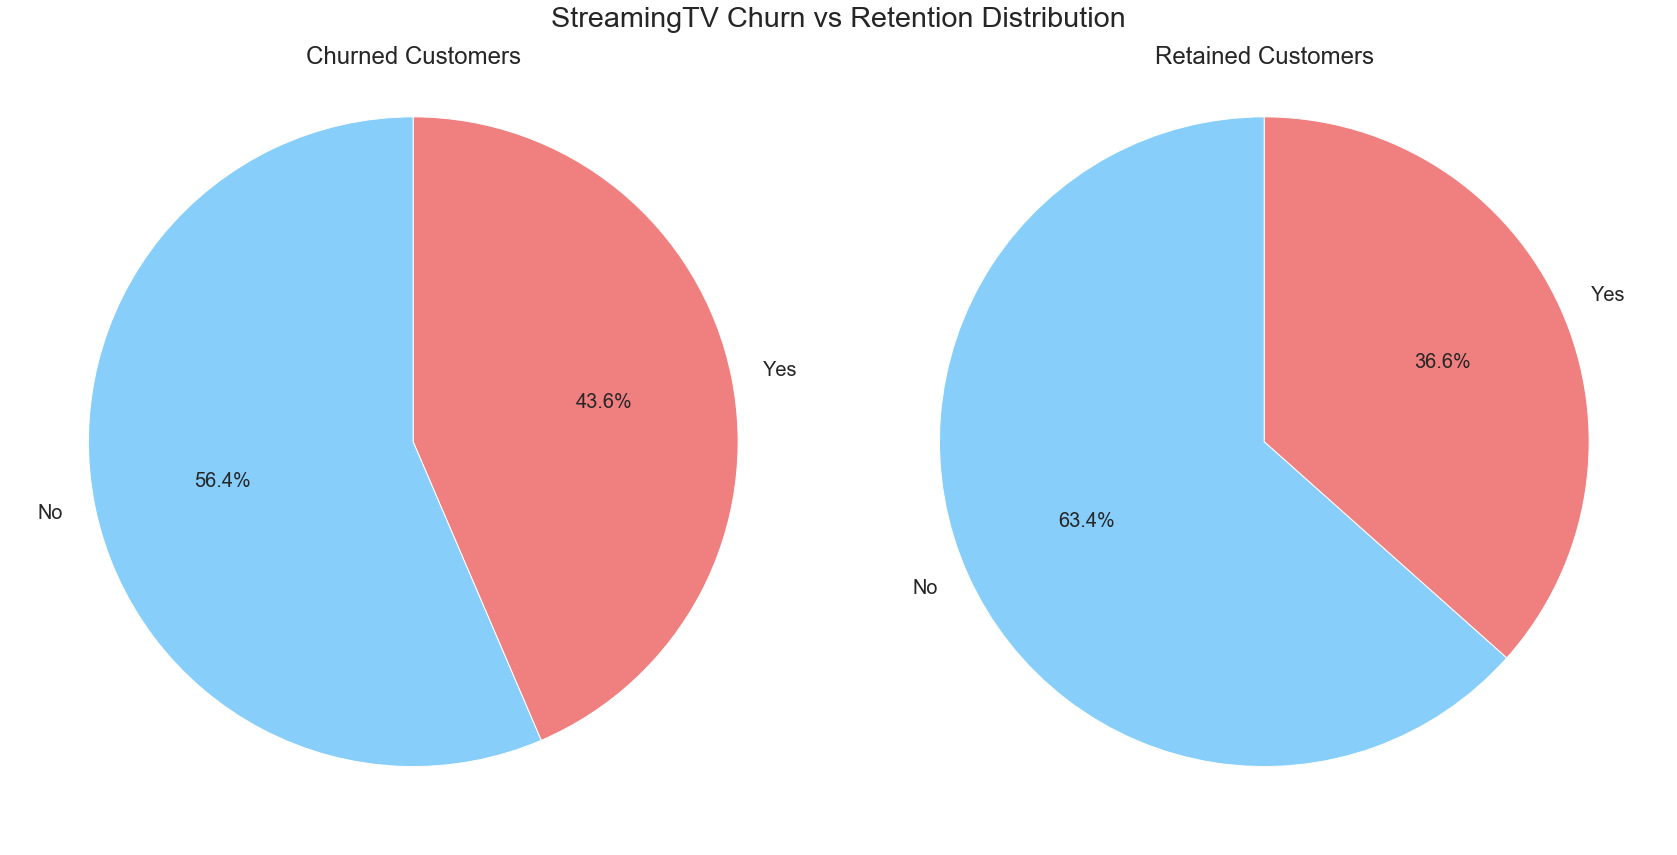

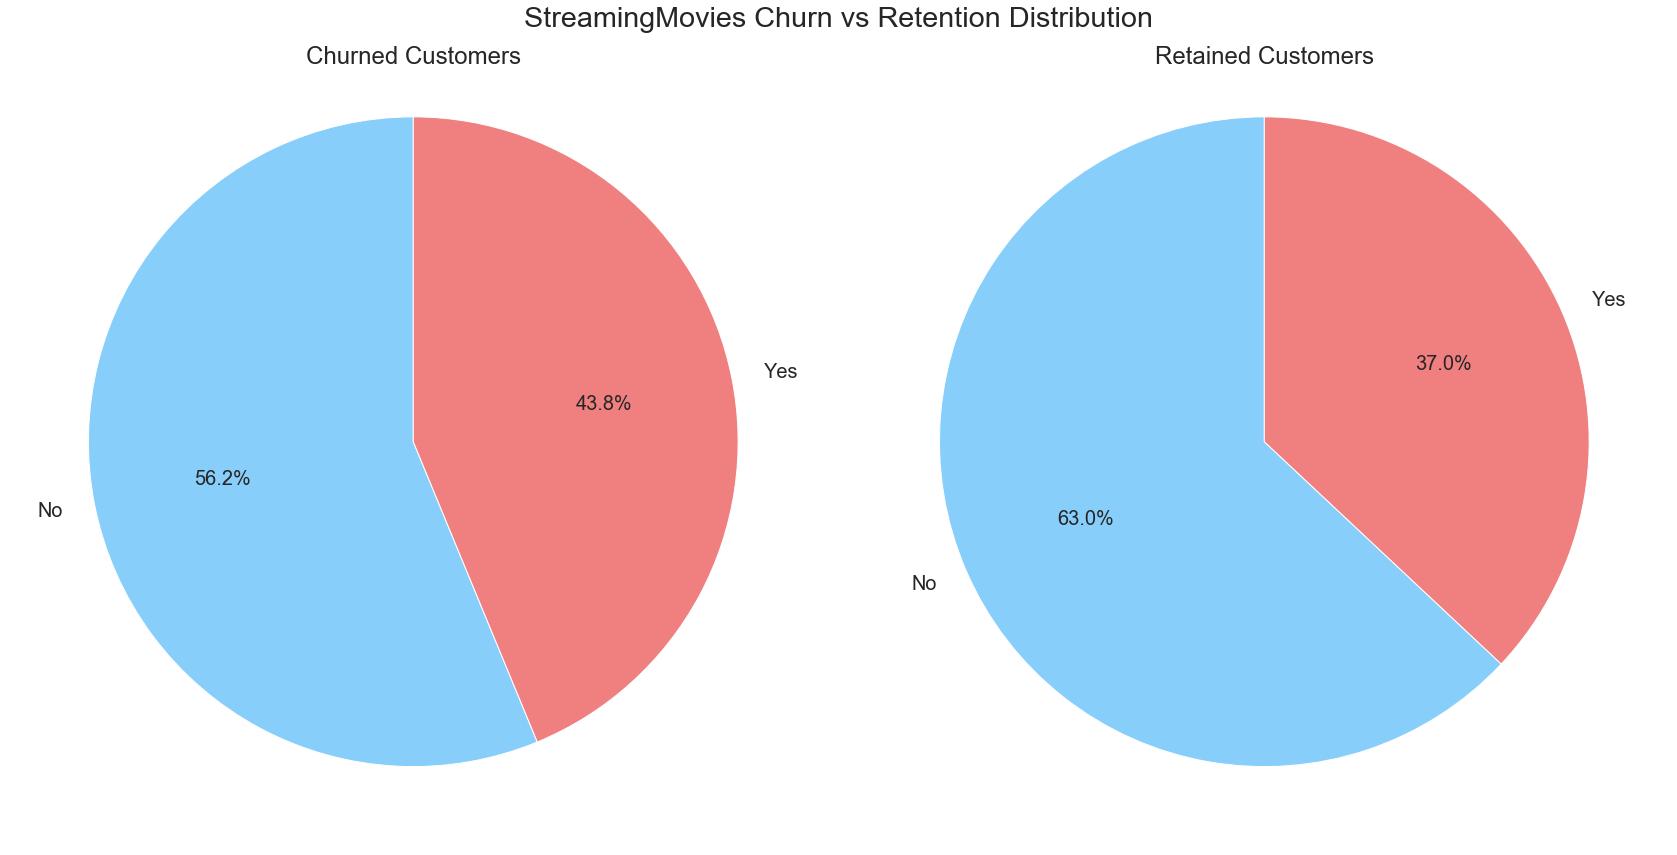

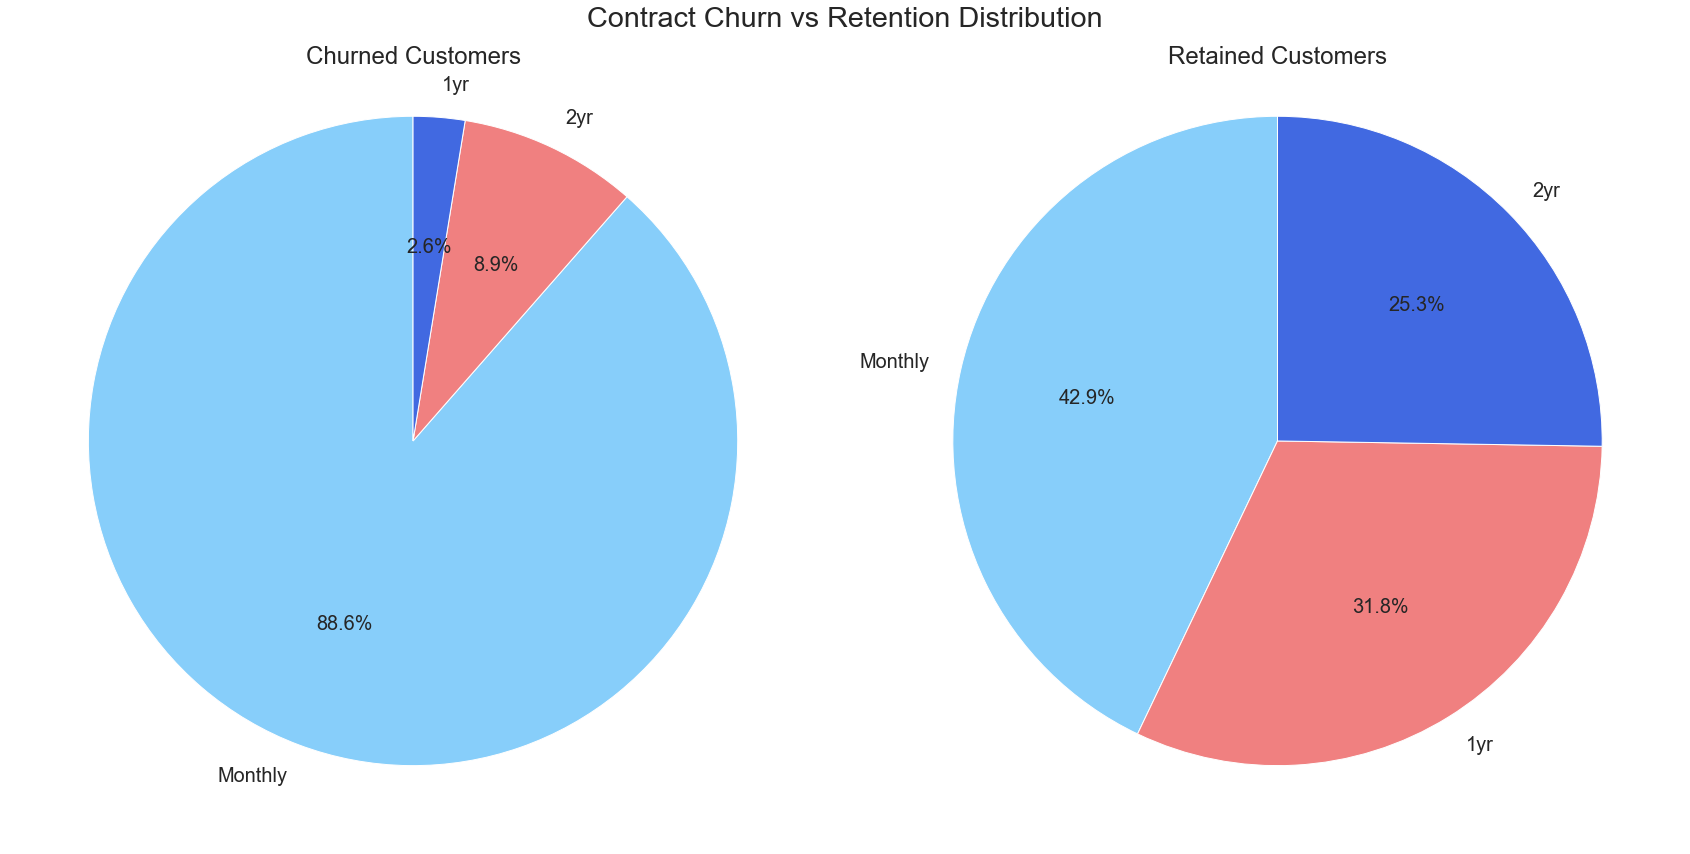

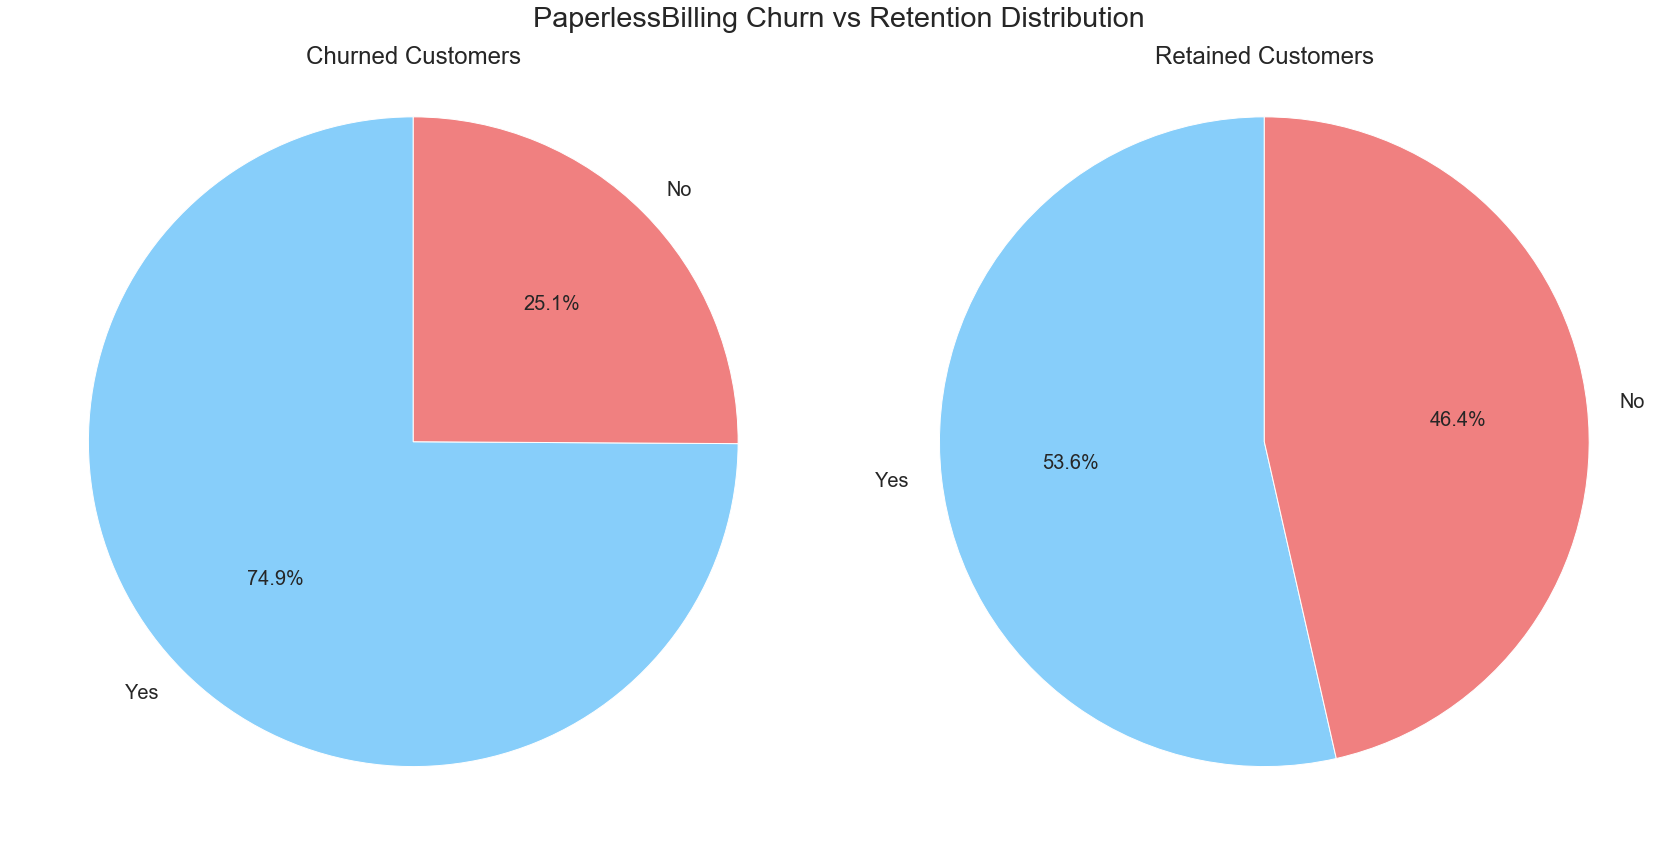

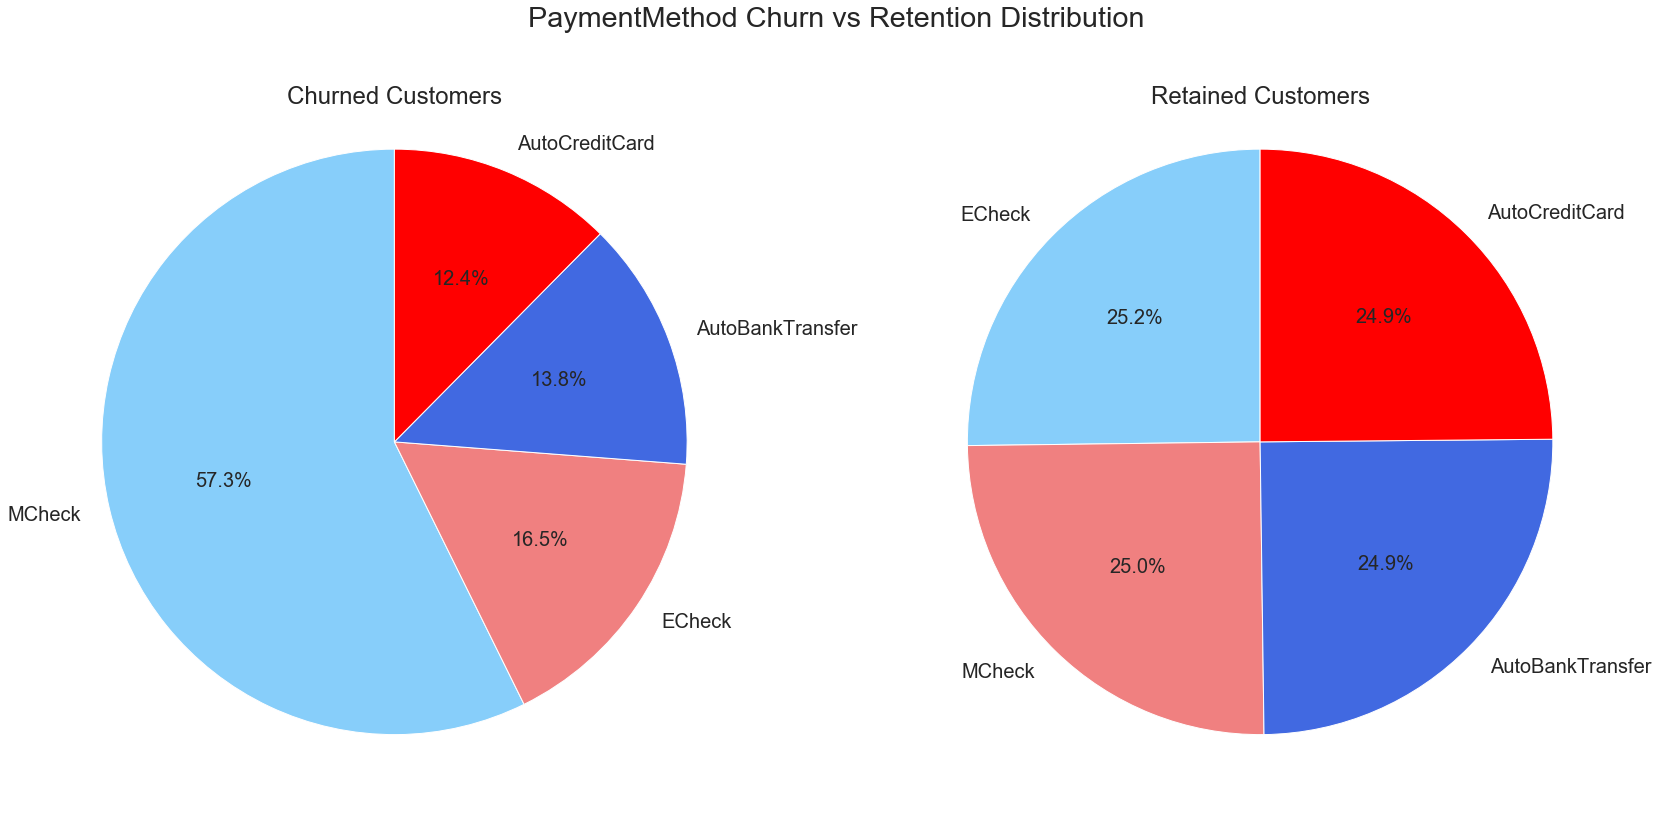

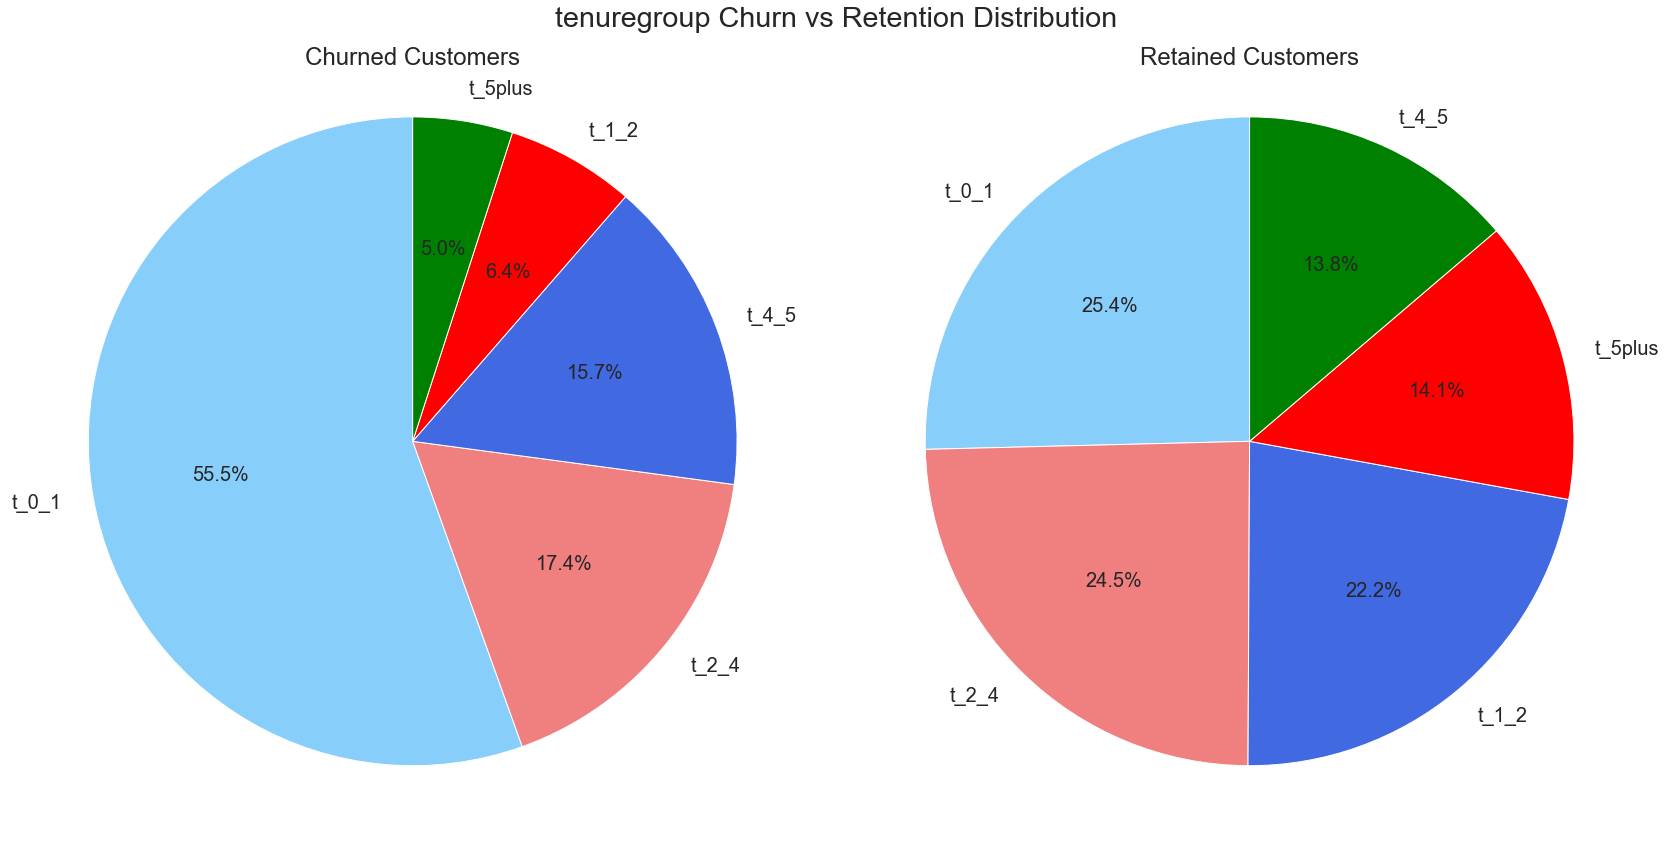

In [86]:
for col in cat_columns:
    category_plots(col)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


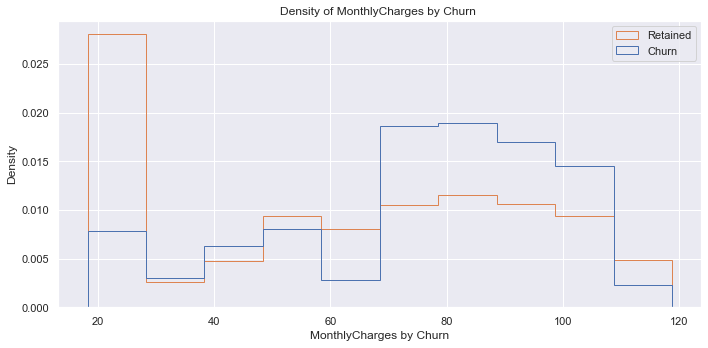

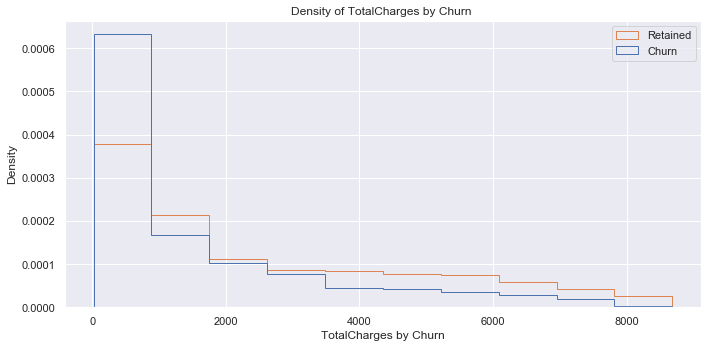

In [91]:
sns.set(font_scale=1)
def continuous_plots(colname):
    churn = churn_customers[colname]
    nochurn = nochurn_customers[colname]

    #Stack the data
    plt.figure(figsize=(10,5))
    plt.hist([churn,nochurn], bins = 10, stacked=False, density=True, label=["Churn","Retained"], histtype="step")
 
    plt.title(f"Density of {colname} by Churn ", {'verticalalignment': 'baseline', 'horizontalalignment': "center"})
    plt.xlabel(f"{colname} by Churn")
    plt.ylabel("Density")
    plt.legend(loc='upper right')
    plt.tight_layout()
    
    plt.show()
    
for col in num_columns:
    continuous_plots(col)

## Bivariate Summary Statistics & Visualizations

In [123]:
# Create a Scatter Matrix
scatter_matrix_df = telecom[["MonthlyCharges","TotalCharges", "Churn"]]

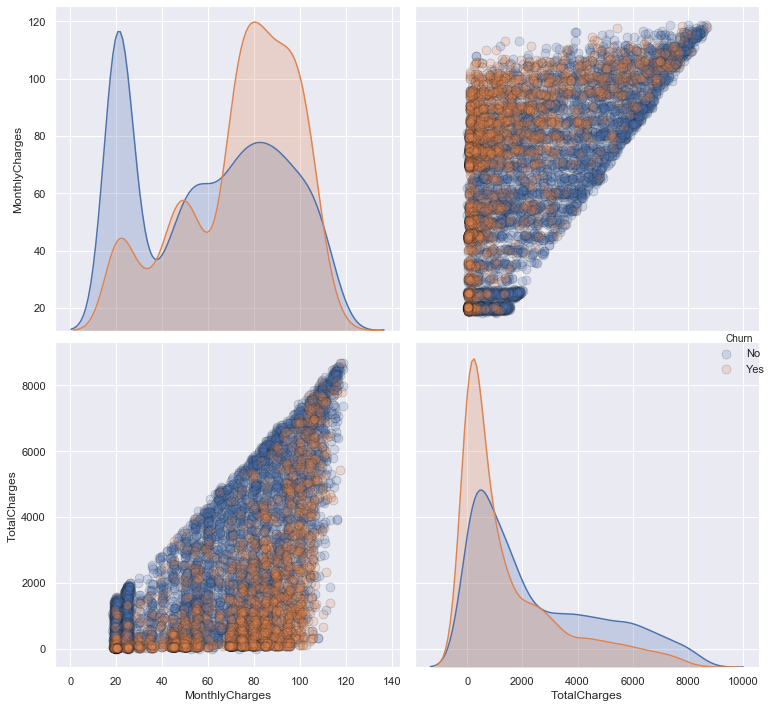

In [34]:
sns.pairplot(scatter_matrix_df, hue = "Churn", diag_kind = "kde",
             plot_kws = {"alpha": 0.2, "s": 80, "edgecolor": "k"},
             height = 5)

plt.tight_layout()

## Obs: There is a strong relationship between:
##       1. MonthlyCharges and TotalCharges
##      The KDEs suggest the density by Churn for each of the continuous variables, which confirms above plots

In [124]:
# Statistics by tenuregroup
churned_tenuregroup = churn_customers.tenuregroup.value_counts().reset_index()
churned_tenuregroup.columns = ["churn_tenuregroup", "frequency"]

churned_tenuregroup

churn_tenuregroup  frequency
0             t_0_1       1037
1             t_2_4        325
2             t_1_2        294
3             t_4_5        120
4           t_5plus         93

In [125]:
retained_tenuregroup = nochurn_customers.tenuregroup.value_counts().reset_index()
retained_tenuregroup.columns = ["retain_tenuregroup", "frequency"]

retained_tenuregroup

retain_tenuregroup  frequency
0            t_5plus       1314
1              t_2_4       1269
2              t_0_1       1149
3              t_1_2        730
4              t_4_5        712

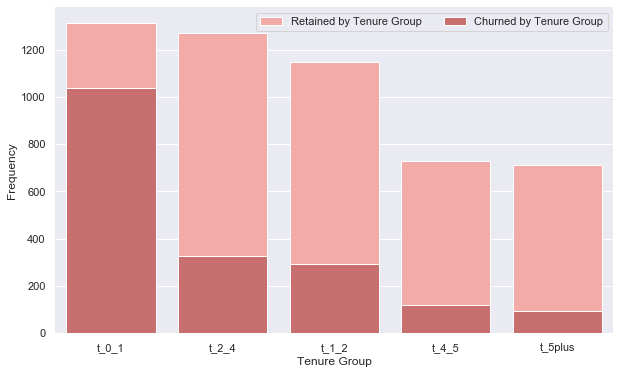

In [90]:
## Plot Churn by Tenure Group
sns.set(font_scale=1)
fig, ax1 = plt.subplots(figsize = (10,6))
sns.set_color_codes('pastel')
sns.barplot(x = 'retain_tenuregroup', y = 'frequency', data = retained_tenuregroup,
            label = 'Retained by Tenure Group', color = 'r', edgecolor = 'w')
sns.set_color_codes('muted')
sns.barplot(x = 'churn_tenuregroup', y = 'frequency', data = churned_tenuregroup,
            label = 'Churned by Tenure Group', color = 'r', edgecolor = 'w')
ax1.legend(ncol = 2, loc = 'upper right')
plt.xlabel("Tenure Group")
plt.ylabel("Frequency")
sns.despine(left = True, bottom = True)
plt.show()

## Obs: The newest customers have the Highest Churn by frequency.

MonthlyCharges  TotalCharges
MonthlyCharges        1.000000      0.651174
TotalCharges          0.651174      1.000000

In [94]:
telecom_corr = telecom.corr(method="pearson")
telecom.corr()

MonthlyCharges  TotalCharges
MonthlyCharges        1.000000      0.651182
TotalCharges          0.651182      1.000000

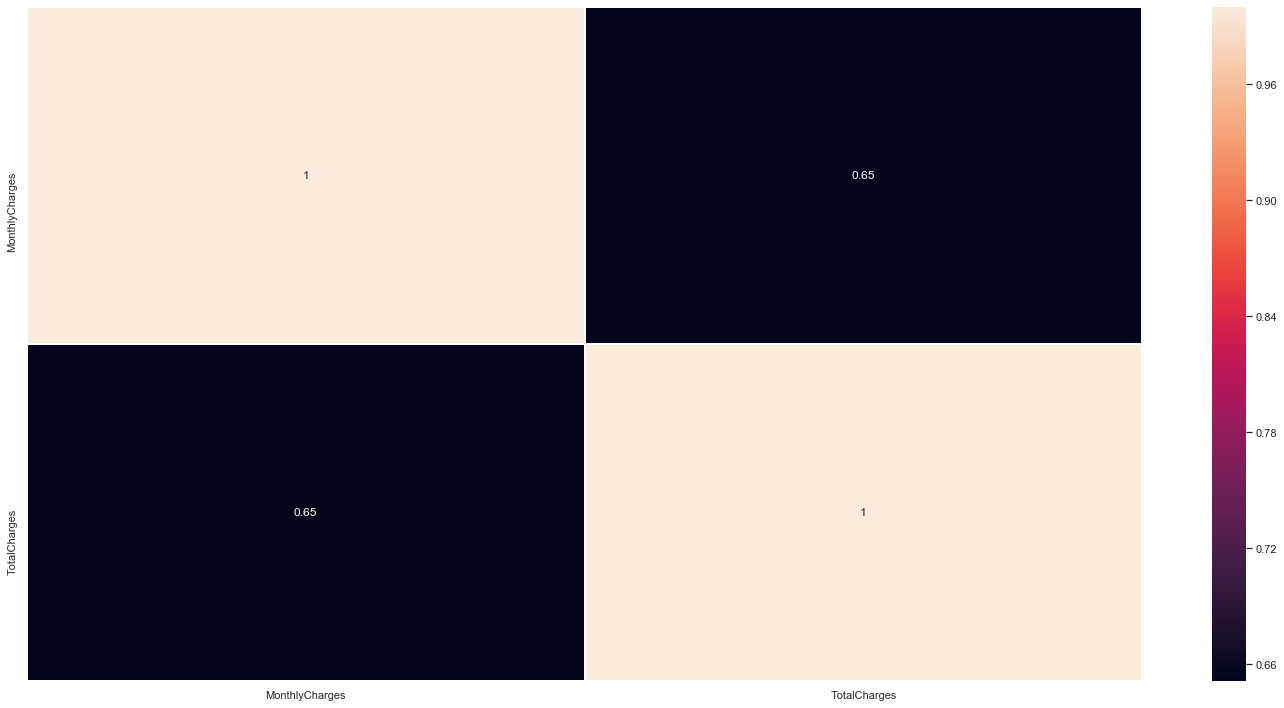

In [95]:
#Plot Heatmap with annotations using seaborn

sns.set()
f, ax = plt.subplots(figsize=(20,10))
sns.heatmap(telecom_corr, annot=True, linewidth=1, ax=ax)
plt.tight_layout()

In [44]:
## Obs: Confirms the observations made in Scatter Plot matrix for continuous features

Categorical eigenvalues: [0.22480591225539087, 0.15269738077833042, 0.10680406901032183, 0.07381444843457918, 0.06743987805929928, 0.059886804184197485, 0.05935575728775159, 0.058919342218039246, 0.05823002279658311, 0.058036579794262744, 0.05265990092767434, 0.04974284305272888, 0.04516780463998177, 0.04383013390883925, 0.041198651681534984, 0.03885089643314873, 0.036493625402742, 0.03545801565472219, 0.03495024448507304]
Numerical eigenvalues: [1.6511819849988034, 0.348818015001196]


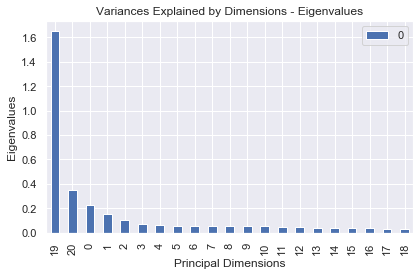

In [180]:
import prince
sns.set(font_scale=1)
tel = telecom.copy(deep=True)
cols = [col for col in tel.columns if col not in ["Churn"]]
df = tel[cols]

famd = prince.FAMD(n_components = 19,
                  n_iter=3,
                  copy=True,
                  check_input=True,
                  engine="auto",
                  random_state=0)
famd = famd.fit(df)

famd_df = pd.DataFrame(columns=["name", "eigenvalues"])
for name, fa in sorted(famd.partial_factor_analysis_.items()):
        famd_df = famd_df.append([{"name":name, "eigenvalues":fa.eigenvalues_}], ignore_index=False)
        print('{} eigenvalues: {}'.format(name, fa.eigenvalues_))
        
famd_cat_eig = famd_df[famd_df["name"]=="Categorical"]["eigenvalues"].values.tolist()
famd_num_eig = famd_df[famd_df["name"]=="Numerical"]["eigenvalues"].values.tolist()
famd_cat_eig = pd.DataFrame(famd_cat_eig).transpose()
famd_num_eig = pd.DataFrame(famd_num_eig).transpose()
famd_eig = pd.concat([famd_cat_eig, famd_num_eig], ignore_index=True)

famd_eig = famd_eig.sort_values(by=0, ascending=False)

ax = famd_eig.plot(kind="bar", title="Variances Explained by Dimensions - Eigenvalues")
ax.set_xlabel("Principal Dimensions")
ax.set_ylabel("Eigenvalues")

plt.tight_layout()

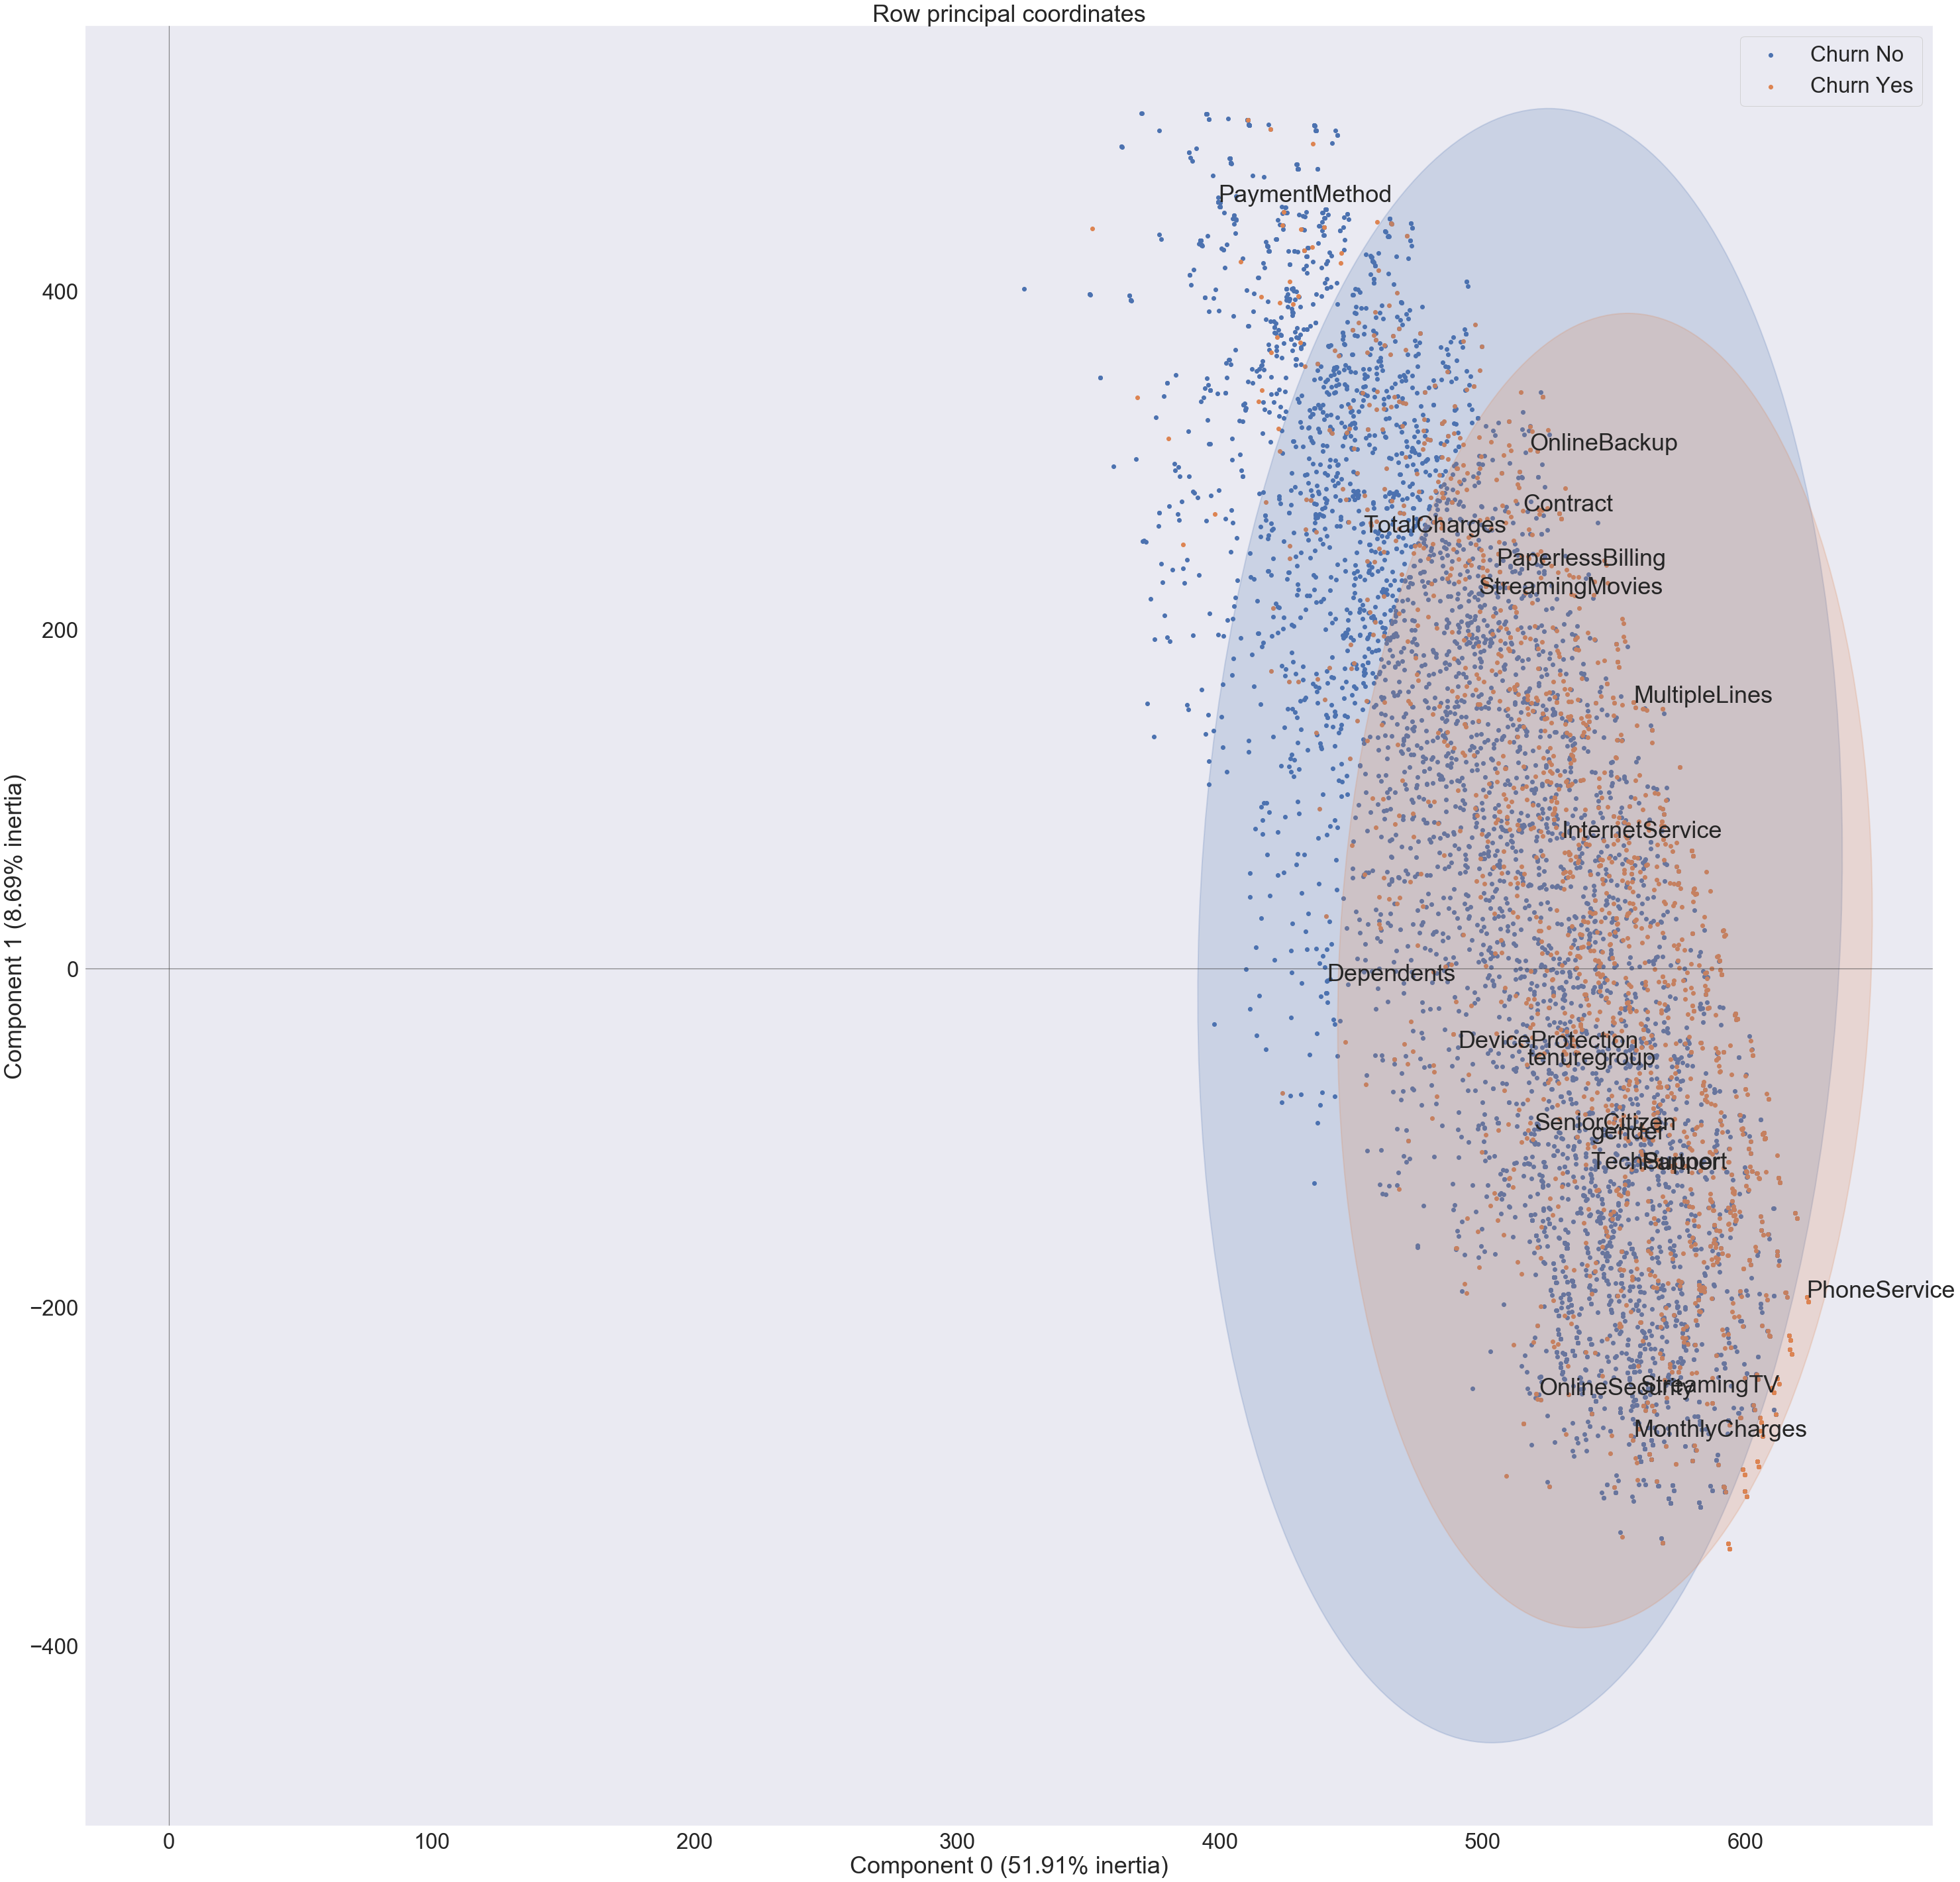

In [193]:
sns.set(font_scale=3)
ax = famd.plot_row_coordinates(
     tel,
     ax=None,
     figsize=(50, 50),
     x_component=0,
     y_component=1,
     labels=df.columns,
     color_labels=['Churn {}'.format(t) for t in tel['Churn']],
     ellipse_outline=True,
     ellipse_fill=True,
     show_points=True,
 )

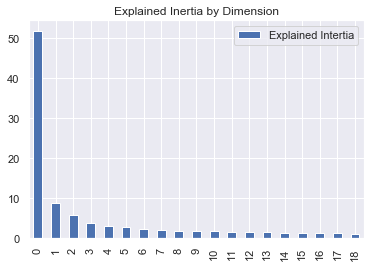

In [194]:
sns.set(font_scale=1)
sum_df = []
for i in famd.explained_inertia_:    
    sum_df.append(i*100)

sum_df = pd.DataFrame(sum_df, columns=["Explained Intertia"])
ax=sum_df.plot(kind="bar", title="Explained Inertia by Dimension")


## Data Pre-processing for further analysis

##### Since the continuous variables have a wide range and different units of measure, it needs to be transformed to a similar Scale for better comparison
##### Can choose between StandardScaler or MinMaxScaler, 
#####       - Outliers have more impact on StandardScaler than MinMaxScaler, but since there are no outliers in the continuous variables Std. Scaler                     is used
##### But Logistic regression fits a model that use a weighted sum of input variables are affected by difference in scale
https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/

#### 1.1. Perform Label Encoding for binary categorical features
#### 1.2. Perform One Hot Encoding for non-binary categorical features
#### 1.3. Perform Data Standardization by Scaling continuous features

In [174]:
telecom.head()

gender SeniorCitizen Partner Dependents PhoneService MultipleLines  \
0  Female             0     Yes         No           No            No   
1    Male             0      No         No          Yes            No   
2    Male             0      No         No          Yes            No   
3    Male             0      No         No           No            No   
4  Female             0      No         No          Yes            No   

  InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
0             DSL             No          Yes               No          No   
1             DSL            Yes           No              Yes          No   
2             DSL            Yes          Yes               No          No   
3             DSL            Yes           No              Yes         Yes   
4      FiberOptic             No           No               No          No   

  StreamingTV StreamingMovies Contract PaperlessBilling     PaymentMethod  \
0          No              No  Monthly              Yes            ECheck   
1          No              No      1yr               No            MCheck   
2          No              No  Monthly              Yes            MCheck   
3          No              No      1yr               No  AutoBankTransfer   
4          No              No  Monthly              Yes            ECheck   

   MonthlyCharges  TotalCharges Churn tenuregroup  
0           29.85     29.850000    No       t_0_1  
1           56.95   1889.500000    No       t_2_4  
2           53.85    108.150002   Yes       t_0_1  
3           42.30   1840.750000    No       t_2_4  
4           70.70    151.649994   Yes       t_0_1

In [97]:
original_telecom = telecom.copy(deep=True) # Save original dataframe for future references

In [175]:
# List Label and One Hot Encoding features

le_columns = [] # features with exactly 2 values 
oh_columns = [] # features with more than 2 values and non-ordinal values
id_col = ["customerID"]
target_col = ["Churn"]

le_columns = telecom.nunique()[telecom.nunique()==2].keys().tolist()
oh_columns = [x for x in cat_columns if x not in le_columns]

In [99]:
# Confirm feature levels for the features
telecom[le_columns].nunique()

gender              2
SeniorCitizen       2
Partner             2
Dependents          2
PhoneService        2
MultipleLines       2
OnlineSecurity      2
OnlineBackup        2
DeviceProtection    2
TechSupport         2
StreamingTV         2
StreamingMovies     2
PaperlessBilling    2
Churn               2
dtype: int64

In [100]:
telecom[oh_columns].nunique()

InternetService    3
Contract           3
PaymentMethod      4
tenuregroup        5
dtype: int64

### Perform Transformations to important features

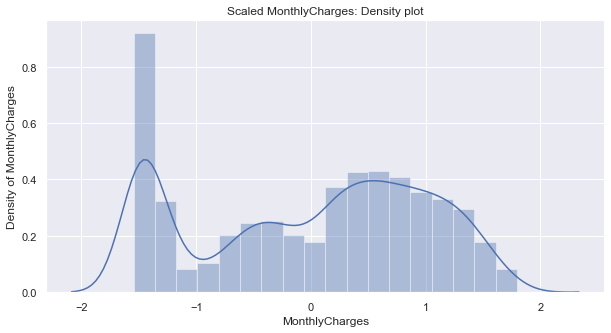

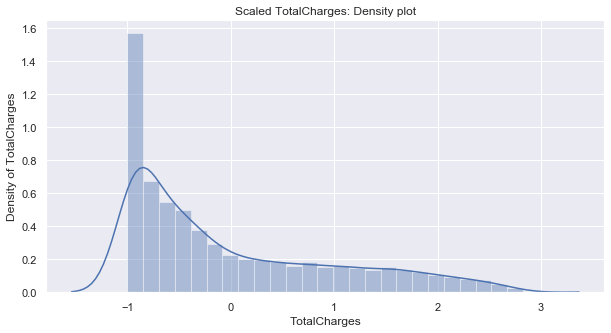

In [101]:
# Perform transformations

le_encode = LabelEncoder()

for l in le_columns:
    telecom[l] = le_encode.fit_transform(telecom[l])
    
#get_dummies for one hot encoding

telecom = pd.get_dummies(data = telecom, columns = oh_columns)

#Scaling Numerical Columns
std = StandardScaler()
scaled = std.fit_transform(telecom[num_columns])
scaled = pd.DataFrame(scaled, columns = num_columns)

for col in scaled.columns:
    plt.figure(figsize=(10,5))    
    plt.tight_layout()
    sns.distplot(scaled[col], kde=True, hist=True).set_title(f"Scaled {col}: Density plot")
    plt.ylabel(f"Density of {col}")

## Obs: The density distribution for the scaled dataset is similar to the original continuous features
## Running this cell again will result in errors, since the telecom df is already transformed

In [102]:
# Compare original and transformed dataset for an example observation
telecom.iloc[:1,:]

gender  SeniorCitizen  Partner  Dependents  PhoneService  MultipleLines  \
0       0              0        1           0             0              0   

   OnlineSecurity  OnlineBackup  DeviceProtection  TechSupport  StreamingTV  \
0               0             1                 0            0            0   

   StreamingMovies  PaperlessBilling  MonthlyCharges  TotalCharges  Churn  \
0                0                 1           29.85         29.85      0   

   InternetService_DSL  InternetService_FiberOptic  InternetService_No  \
0                    1                           0                   0   

   Contract_1yr  Contract_2yr  Contract_Monthly  \
0             0             0                 1   

   PaymentMethod_AutoBankTransfer  PaymentMethod_AutoCreditCard  \
0                               0                             0   

   PaymentMethod_ECheck  PaymentMethod_MCheck  tenuregroup_t_0_1  \
0                     1                     0                  1   

   tenuregroup_t_1_2  tenuregroup_t_2_4  tenuregroup_t_4_5  \
0                  0                  0                  0   

   tenuregroup_t_5plus  
0                    0

In [103]:
original_telecom.iloc[:1,:]

gender SeniorCitizen Partner Dependents PhoneService MultipleLines  \
0  Female             0     Yes         No           No            No   

  InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
0             DSL             No          Yes               No          No   

  StreamingTV StreamingMovies Contract PaperlessBilling PaymentMethod  \
0          No              No  Monthly              Yes        ECheck   

   MonthlyCharges  TotalCharges Churn tenuregroup  
0           29.85         29.85    No       t_0_1

In [104]:
# Merge scaled transformed continuous features to the telecom data set & drop original continuous features
#1. Drop old features
telecom = telecom.drop(columns=num_columns, axis=1) 
#2. Add scaled features
telecom = telecom.merge(scaled, left_index=True, right_index=True, how="left")

telecom.head()

gender  SeniorCitizen  Partner  Dependents  PhoneService  MultipleLines  \
0       0              0        1           0             0              0   
1       1              0        0           0             1              0   
2       1              0        0           0             1              0   
3       1              0        0           0             0              0   
4       0              0        0           0             1              0   

   OnlineSecurity  OnlineBackup  DeviceProtection  TechSupport  StreamingTV  \
0               0             1                 0            0            0   
1               1             0                 1            0            0   
2               1             1                 0            0            0   
3               1             0                 1            1            0   
4               0             0                 0            0            0   

   StreamingMovies  PaperlessBilling  Churn  InternetService_DSL  \
0                0                 1      0                    1   
1                0                 0      0                    1   
2                0                 1      1                    1   
3                0                 0      0                    1   
4                0                 1      1                    0   

   InternetService_FiberOptic  InternetService_No  Contract_1yr  Contract_2yr  \
0                           0                   0             0             0   
1                           0                   0             1             0   
2                           0                   0             0             0   
3                           0                   0             1             0   
4                           1                   0             0             0   

   Contract_Monthly  PaymentMethod_AutoBankTransfer  \
0                 1                               0   
1                 0                               0   
2                 1                               0   
3                 0                               1   
4                 1                               0   

   PaymentMethod_AutoCreditCard  PaymentMethod_ECheck  PaymentMethod_MCheck  \
0                             0                     1                     0   
1                             0                     0                     1   
2                             0                     0                     1   
3                             0                     0                     0   
4                             0                     1                     0   

   tenuregroup_t_0_1  tenuregroup_t_1_2  tenuregroup_t_2_4  tenuregroup_t_4_5  \
0                  1                  0                  0                  0   
1                  0                  0                  1                  0   
2                  1                  0                  0                  0   
3                  0                  0                  1                  0   
4                  1                  0                  0                  0   

   tenuregroup_t_5plus  MonthlyCharges  TotalCharges  
0                    0       -1.160323     -0.992667  
1                    0       -0.259629     -0.172198  
2                    0       -0.362660     -0.958122  
3                    0       -0.746535     -0.193706  
4                    0        0.197365     -0.938930

In [106]:
# Saved the Cleaned, Untransformed data set
file_path = "../data/external/Telco_Customer_Churn_cleaned.xlsx"

writer = pd.ExcelWriter(file_path, engine = 'xlsxwriter')
original_telecom.to_excel(writer, index = False,sheet_name='Telco_cleaned_NoTransform')
telecom.to_excel(writer, index = False,sheet_name='Telco_TransformedData')
writer.save()
writer.close()

### Create a correlation matrix for transformed data

In [107]:
telecom_corr = telecom.corr(method="pearson")

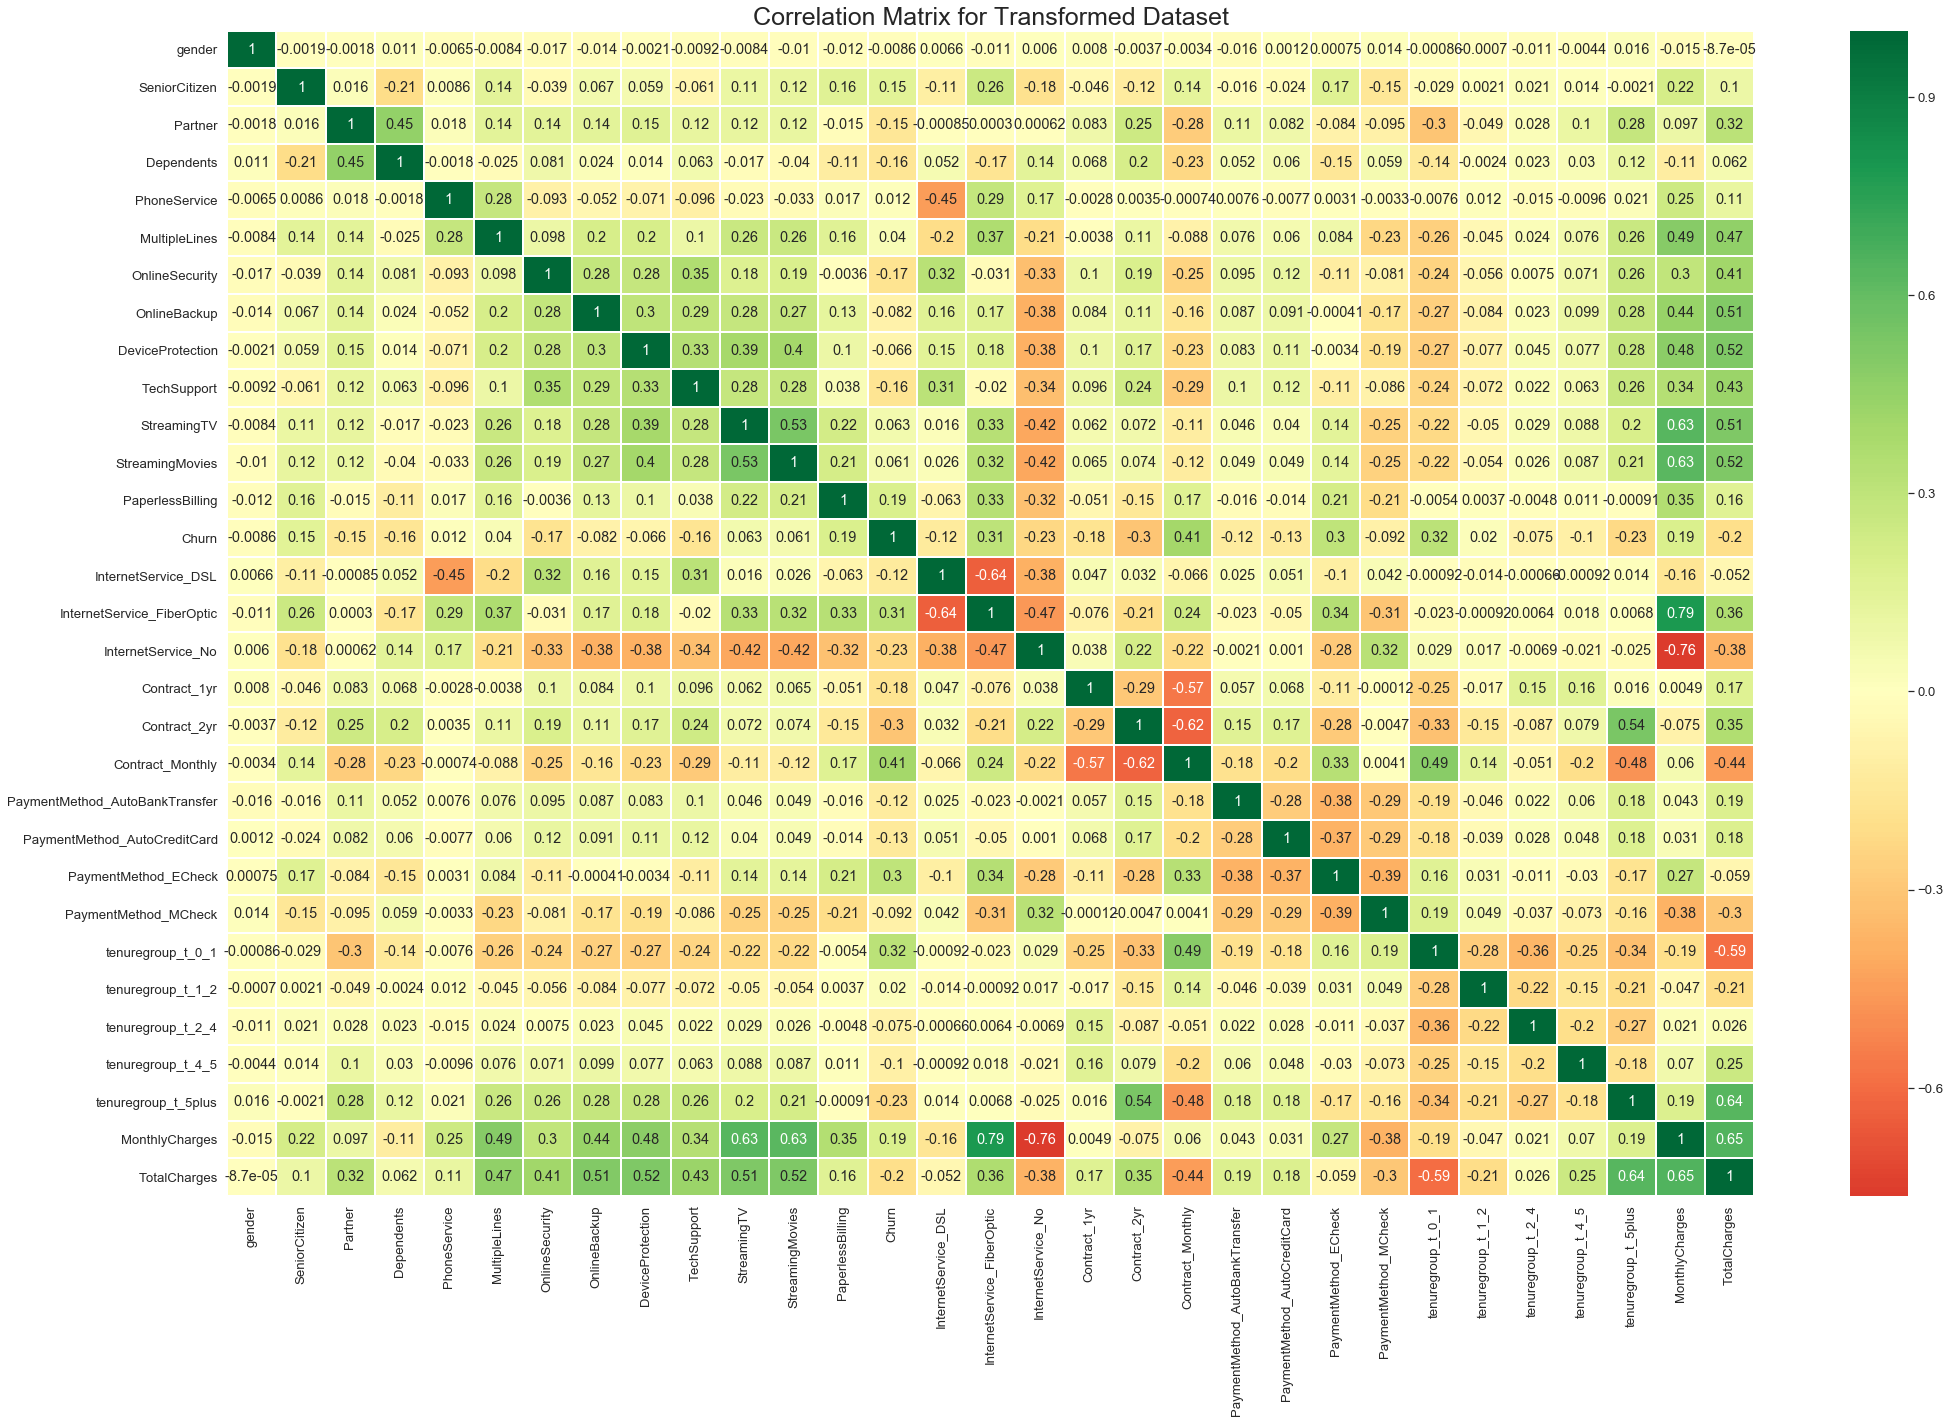

In [108]:
#Plot Heatmap with annotations using seaborn

sns.set(font_scale=1.2)
plt.figure(figsize=(30,20))
sns.heatmap(telecom_corr, annot=True, linewidth=1, center=0, cmap="RdYlGn")
plt.title("Correlation Matrix for Transformed Dataset", fontsize=25)
plt.tight_layout()


# Create Models using Sci-kit Learn for Advanced Analysis & Prediction

## Splitting Data into "Training" and "Test" sub-sets for Model Performance Assessments
### 1. Train-Test Split

In [57]:
# Prepare data for split
telecom_y = []
telecom_y = telecom["Churn"].ravel()
telecom_x = telecom.copy(deep=True)
telecom_x = telecom.drop(columns = ["Churn"], axis=1) # Customer ID is not relevant for current analysis

# Split Data
X_train, X_test, y_train, y_test = train_test_split(telecom_x, telecom_y, test_size= 0.25, random_state=0, shuffle=True)

del telecom_y, telecom_x # release memory since these dfs are no longer required

In [58]:
np.nanmean(y_train), np.nanmean(y_test)

#Similar means = the split is not imbalanced

(0.26618705035971224, 0.2629187961385576)

In [59]:
# Define required functions for repeated executions

#1. Get Model Scores

def model_scores(model_name, model, Xtest, ytest, predictions,idx):
    model_acc = model.score(Xtest, ytest)
    model_recall = recall_score(ytest,np.array(predictions))
    model_precision = precision_score(ytest,np.array(predictions))
    model_auc = roc_auc_score(ytest,np.array(predictions))
    model_f1 = f1_score(ytest, np.array(predictions))
    model_classreport = classification_report(ytest, np.array(predictions))
    model_cm = confusion_matrix(ytest, np.array(predictions))
    
    print("\033[1m Classification Report: \033[0;0m\n", model_classreport)
    print("\033[1m Accuracy Score: \033[0;0m\n", model_acc)    
    print(f"\033[1m Precision: \033[0;0m{model_precision}\033[1m  & Recall Scores: \033[0;0m{model_recall}\n")
    print("\033[1m F1 Score: \033[0;0m\n", model_f1)
    print("\033[1m AUC: \033[0;0m\n", model_auc)
    
    comp_cols = ["ModelName", "AccuracyScore", "RecallScore", "PrecisionScore", "F1Score", "AreaUnderCurve" ]
        
    df = []
    df = (pd.DataFrame({"ModelName": model_name, 
                        "AccuracyScore":model_acc,
                        "RecallScore": model_recall,
                        "PrecisionScore": model_precision,
                        "F1Score": model_f1,
                        "AreaUnderCurve": model_auc
                        }, 
                       index=[idx])
         )
        
    plot_confusionmatrix(model_name, model_cm)
    
    fpr, tpr, thresholds = roc_curve(ytest, model.predict_proba(Xtest)[:,1])
    plot_roc_auc(model_name, model_auc, fpr, tpr)
    
    return df
    
    
#2. Plot Confusion Matrix for the models
def plot_confusionmatrix(algorithm, conf_matrix):
    classes = ["Retained Customers", "Churn Customers"]
    plt.figure(figsize=(7,7))
    plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(f"{algorithm}: Confusion Matrix")
    plt. colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=14)
    plt.yticks(tick_marks, classes, size=14)
    fmt = "d"
    thresh = conf_matrix.max()/2

    #Labeling the plot
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
            plt.text(j, i, format(conf_matrix[i, j], fmt), fontsize = 15,
                     horizontalalignment="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 15)
    plt.xlabel('Predicted label', size = 15)
    
#3. Plot ROC-AUC Curve
def plot_roc_auc(algorithm, roc_auc, fpr, tpr):
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, label="Model (area = %0.2f)" %roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{algorithm} Receiver Operating Characteristic")
    plt.legend(loc="lower right")    
    plt.grid(True)
    plt.show()
    
#4. Plot Precision Recall Curve

def plot_precision_recall(ytest, yscore):
    precision, recall, thresholds = precision_recall_curve(ytest, yscore)
    plt.plot(thresholds, precision[:len(precision)-1], label='Precision', ls = 'dashed') 
    plt.plot(thresholds, recall[:len(recall)-1], label='Recall', ls = 'dashed') 
    plt.legend(loc="best")
    plt.title('Precision and Recall scores by Decision Threshold') 
    plt.xlabel('Threshold')
    plt.ylabel('Metrics value')
    plt.grid(True)

### 1. Create Dummy Baseline Model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 Classification Report: 
               precision    recall  f1-score   support

           0       0.74      1.00      0.85      1298
           1       0.00      0.00      0.00       463

    accuracy                           0.74      1761
   macro avg       0.37      0.50      0.42      1761
weighted avg       0.54      0.74      0.63      1761

 Accuracy Score: 
 0.7370812038614424
 Precision: 0.0  & Recall Scores: 0.0

 F1 Score: 
 0.0
 AUC: 
 0.5


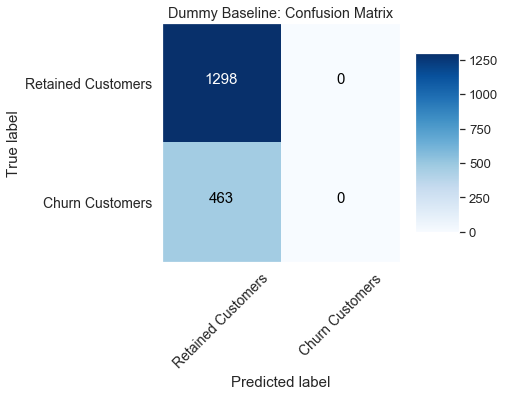

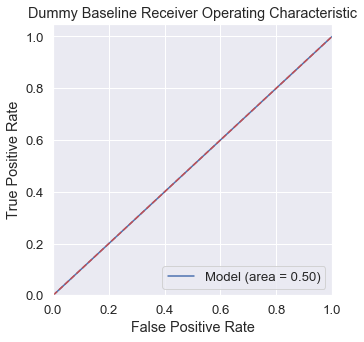

ModelName  AccuracyScore  RecallScore  PrecisionScore  F1Score  \
0  Dummy Baseline       0.737081          0.0             0.0      0.0   

   AreaUnderCurve  
0             0.5

In [63]:
dummy_model = DummyClassifier(strategy="most_frequent", random_state=0)

# Train Dummy Baseline
dummy_model.fit(X_train, y_train)

#Generate Prediction
base_predictions = dummy_model.predict(X_test)

# Display Scores & Confusion Matrix
model_comparison = pd.DataFrame(model_scores("Dummy Baseline", dummy_model, X_test, y_test, base_predictions,0), 
                                columns=["ModelName", 
                                         "AccuracyScore", 
                                         "RecallScore", 
                                         "PrecisionScore", 
                                         "F1Score", 
                                         "AreaUnderCurve" ]
                               )
model_comparison = model_comparison.drop_duplicates() # In case this cell is rerun
model_comparison

### Over Sampling the train sets using SMOTE (Synthetic Minority Oversampling Technique)
###   - Up sample "Churned Customers" in the training dataset

In [64]:
x_cols = X_train.columns.tolist()
y_cols = ["Churn"]

In [65]:
#oversampling minority class using smote

over_sample = SMOTE(random_state = 0)

os_data_X, os_data_y = over_sample.fit_sample(X_train, y_train)

os_data_X = pd.DataFrame(data=os_data_X, columns=x_cols)
os_data_y = pd.DataFrame(data=os_data_y, columns=y_cols)

#Check the details after SMOTE runs
retain_count = len(os_data_y[os_data_y["Churn"]==0])
churn_count = len(os_data_y[os_data_y["Churn"]==1])

print(f"Total count of Oversampled data: {len(os_data_X)}")
print(f"Number of Retained Customer count in Oversample data: {retain_count}")
print(f"Number of Churned Customer count in Oversample data: {churn_count}")
print(f"Proportion of Retained Customer data: {retain_count/len(os_data_X)}")
print(f"Proportion of Churned Customer data: {churn_count/len(os_data_X)}")

Total count of Oversampled data: 7752
Number of Retained Customer count in Oversample data: 3876
Number of Churned Customer count in Oversample data: 3876
Proportion of Retained Customer data: 0.5
Proportion of Churned Customer data: 0.5


In [66]:
## Obs: Imbalanced classes from the target variable has been addressed and these data sets are to be used for further modelling

### Dimension Reduction - Remove features which would not contribute to the model's performance
### Use RFE (Recursive Feature Elimination)
####   - Repeatedly construct a model and choose either the best or worst performing feature

In [67]:
# Create RFE Model
# use x_cols and y_cols from above for column information

log_regr = LogisticRegression(solver="liblinear")

rfe = RFE(log_regr, 15) #Select top 15 features from 31 -> try and reduce the # of features by 50% approx.
rfe.fit(os_data_X, os_data_y.values.ravel())

rfe_ranking = pd.DataFrame( {"Features" : os_data_X.columns.tolist(),
                             "rfe_support": rfe.support_,                             
                             "rfe_ranking": rfe.ranking_})
rfe_ranking.sort_values(by="rfe_ranking", inplace=True)
rfe_ranking

## Obs: Based on the RFE model, we know that out of 31 features, top 15 features are listed below. 
## These can be further reduced based on the p-values for each 

Features  rfe_support  rfe_ranking
25               tenuregroup_t_2-4         True            1
22            PaymentMethod_MCheck         True            1
21            PaymentMethod_ECheck         True            1
20    PaymentMethod_AutoCreditCard         True            1
19  PaymentMethod_AutoBankTransfer         True            1
18                Contract_Monthly         True            1
17                    Contract_2yr         True            1
16                    Contract_1yr         True            1
28                  MonthlyCharges         True            1
24               tenuregroup_t_1-2         True            1
6                   OnlineSecurity         True            1
4                     PhoneService         True            1
26               tenuregroup_t_4-5         True            1
27             tenuregroup_t_5plus         True            1
9                      TechSupport         True            1
7                     OnlineBackup        False            2
11                 StreamingMovies        False            3
14      InternetService_FiberOptic        False            4
15              InternetService_No        False            5
10                     StreamingTV        False            6
8                 DeviceProtection        False            7
23               tenuregroup_t_0-1        False            8
5                    MultipleLines        False            9
3                       Dependents        False           10
13             InternetService_DSL        False           11
0                           gender        False           12
2                          Partner        False           13
12                PaperlessBilling        False           14
1                    SeniorCitizen        False           15
29                    TotalCharges        False           16

In [68]:
# Output top 15 columns from RFE process
rfe_cols = rfe_ranking[rfe_ranking["rfe_support"] == True]["Features"].tolist()

# Build new training dataframes with the above selected columns
X = os_data_X[rfe_cols]
y = os_data_y

### Implementing Stats Model to get the p-values of each of the selected columns

In [69]:
stats_logitmodel = sm.Logit(y, X)
result = stats_logitmodel.fit()
print("Summary: \n",result.summary2())

Optimization terminated successfully.
         Current function value: 0.452454
         Iterations 7
Summary: 
                                 Results: Logit
Model:                   Logit                 Pseudo R-squared:      0.347    
Dependent Variable:      Churn                 AIC:                   7044.8536
Date:                    2020-07-27 22:56      BIC:                   7149.1892
No. Observations:        7752                  Log-Likelihood:        -3507.4  
Df Model:                14                    LL-Null:               -5373.3  
Df Residuals:            7737                  LLR p-value:           0.0000   
Converged:               1.0000                Scale:                 1.0000   
No. Iterations:          7.0000                                                
-------------------------------------------------------------------------------
                                Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------

In [70]:
# Remove columns with p-value more than significance value of 0.05
remove_cols = ["Contract_2yr", "PhoneService"]
final_cols = [i for i in X.columns if i not in remove_cols]

X = os_data_X[final_cols]
y = os_data_y["Churn"]

print(f"Total number of Observations in Oversampled X: {len(X)} & Oversampled y: {len(y)}")

Total number of Observations in Oversampled X: 7752 & Oversampled y: 7752


#### Make sure the p-values are correct for remaining features

In [71]:
stats_logitmodel = sm.Logit(y, X)
result = stats_logitmodel.fit()
print("Summary: \n",result.summary2())

Optimization terminated successfully.
         Current function value: 0.452524
         Iterations 7
Summary: 
                                 Results: Logit
Model:                   Logit                 Pseudo R-squared:      0.347    
Dependent Variable:      Churn                 AIC:                   7041.9284
Date:                    2020-07-27 22:57      BIC:                   7132.3526
No. Observations:        7752                  Log-Likelihood:        -3508.0  
Df Model:                12                    LL-Null:               -5373.3  
Df Residuals:            7739                  LLR p-value:           0.0000   
Converged:               1.0000                Scale:                 1.0000   
No. Iterations:          7.0000                                                
-------------------------------------------------------------------------------
                                Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------

Optimization terminated successfully.
         Current function value: 0.425046
         Iterations 8


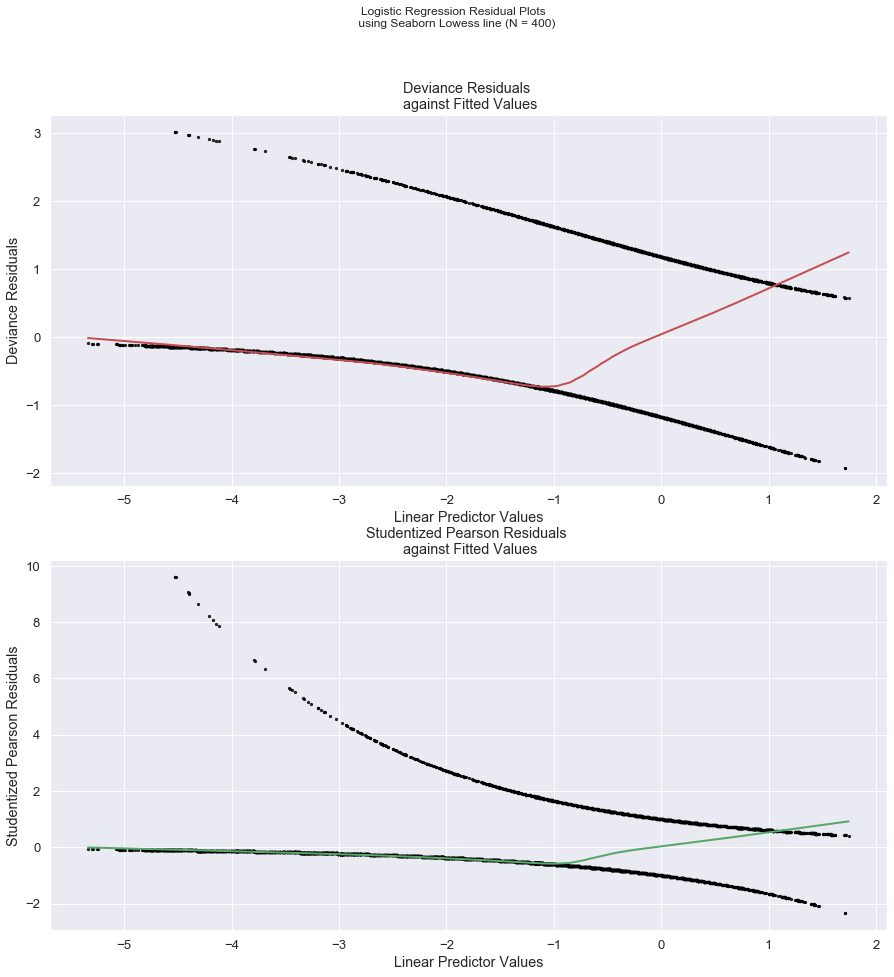

In [167]:
# Check Logistic Regression Assumptions for Logistic Regression Residuals
tel = telecom.copy(deep=True)
tel = tel.rename(columns={"tenuregroup_t_2-4":"tg24", 
                          "tenuregroup_t_1-2":"tg12", 
                          "tenuregroup_t_4-5":"tg45",
                          "tenuregroup_t_0-1":"tg01",
                          "tenuregroup_t_5plus":"tg5"})
tel.head(1)
model = smf.logit("Churn~MonthlyCharges+tg24+PaymentMethod_MCheck+PaymentMethod_ECheck+PaymentMethod_AutoCreditCard+PaymentMethod_AutoBankTransfer+Contract_Monthly+Contract_1yr+tg12+OnlineSecurity+tg45+tg5+TechSupport", data = tel).fit()

## Plotting multiple plots same figure
fig, (axL, axR) = plt.subplots(2, figsize=(15, 15))
plt.suptitle("Logistic Regression Residual Plots \n using Seaborn Lowess line (N = 400)")

# Deviance Residuals
sns.regplot(model.fittedvalues, model.resid_dev, ax= axL,
            color="black", scatter_kws={"s": 5},
            line_kws={"color":"r", "alpha":1, "lw":2}, lowess=True)

axL.set_title("Deviance Residuals \n against Fitted Values")
axL.set_xlabel("Linear Predictor Values")
axL.set_ylabel("Deviance Residuals")

#Pearson Residuals
sns.regplot(model.fittedvalues, model.resid_pearson, ax= axR,
            color="black", scatter_kws={"s": 5},
            line_kws={"color":"g", "alpha":1, "lw":2}, lowess=True)

axR.set_title("Pearson Residuals \n against Fitted Values")
axR.set_xlabel("Linear Predictor Values")
axR.set_ylabel("Pearson Residuals")

plt.show()

# Build Logistic Regression Model with Default Parameters

 Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.79      0.80       984
           1       0.79      0.81      0.80       954

    accuracy                           0.80      1938
   macro avg       0.80      0.80      0.80      1938
weighted avg       0.80      0.80      0.80      1938

 Accuracy Score: 
 0.7977296181630547
 Precision: 0.7885010266940452  & Recall Scores: 0.8050314465408805

 F1 Score: 
 0.7966804979253113
 AUC: 
 0.7978409265224727


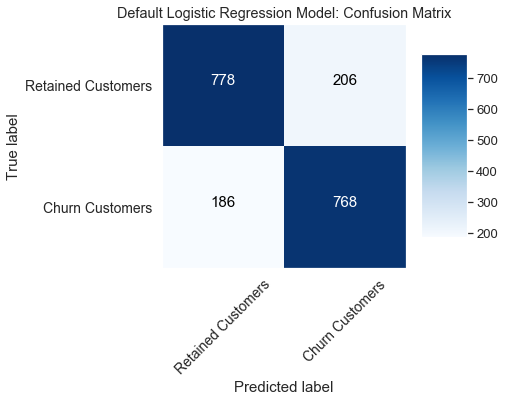

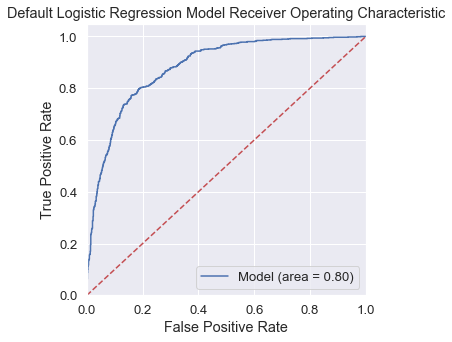

ModelName  AccuracyScore  RecallScore  \
0                     Dummy Baseline       0.737081     0.000000   
1  Default Logistic Regression Model       0.797730     0.805031   

   PrecisionScore  F1Score  AreaUnderCurve  
0        0.000000  0.00000        0.500000  
1        0.788501  0.79668        0.797841

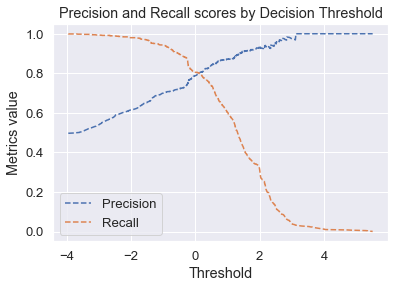

In [73]:
# Split the oversampled "balanced" training data set again, since the old training data was imbalanced.
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size= 0.25, random_state=0)

# Create Logistic Regression model with Default parameters
lr_model = LogisticRegression(solver="liblinear")

# Train the model
lr_model.fit(X_train, y_train)

# Predict the results from testing set & calculate model performance
lr_predictions = lr_model.predict(X_test)

#model_comparison = model_comparison.drop(index=0, axis=0)
model_comparison = model_comparison.append(model_scores(model_name = "Default Logistic Regression Model", 
                                                        model = lr_model, 
                                                        Xtest = X_test,
                                                        ytest = y_test, 
                                                        predictions = lr_predictions, 
                                                        idx=1),
                                           ignore_index=False)

model_comparison = model_comparison.drop_duplicates() #Incase this cell is run again. 

y_score = lr_model.decision_function(X_test)
plot_precision_recall(y_test, y_score)

model_comparison

### Hyperparameter tuning for Logistic Regression Model

In [75]:
# Get a list of all Metrics Scorers that can be used to tune hyperparameters
# Since the focus is on recall scores, more than precision setting the scoring to "recall"
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [110]:
class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.65, 0:0.3}, {1:0.7, 0:0.3}]
parameters = {"C": [0.001, 0.001,0.1, 1, 10, 100, 1000],
              "penalty": ["l1", "l2"], 
              "class_weight": class_weight, 
              "solver" : ['liblinear', 'saga']}

cv_model = GridSearchCV(lr_model, 
                        param_grid = parameters, 
                        cv = 3, 
                        scoring="f1",
                        verbose=1, 
                        n_jobs=-1) # perform 3 fold validation

cv_result = cv_model.fit(X_train, y_train)

print(f"Best Parameters: {cv_model.best_params_} \n")
print(f"Best Score after HPO: {cv_model.best_score_} \n")
print(f"Best Model Accuracy Score after Hyperparameter Optimization: {cv_model.score(X_test, y_test)}")

Fitting 3 folds for each of 140 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.3s


Best Parameters: {'C': 1, 'class_weight': {1: 0.6, 0: 0.4}, 'penalty': 'l1', 'solver': 'saga'} 

Best Score after HPO: 0.8092044382140862 

Best Model Accuracy Score after Hyperparameter Optimization: 0.7999999999999999


[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:    7.2s finished


 Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.68      0.76       984
           1       0.73      0.89      0.80       954

    accuracy                           0.78      1938
   macro avg       0.79      0.78      0.78      1938
weighted avg       0.80      0.78      0.78      1938

 Accuracy Score: 
 0.7999999999999999
 Precision: 0.7272727272727273  & Recall Scores: 0.8888888888888888

 F1 Score: 
 0.7999999999999999
 AUC: 
 0.7828590785907859


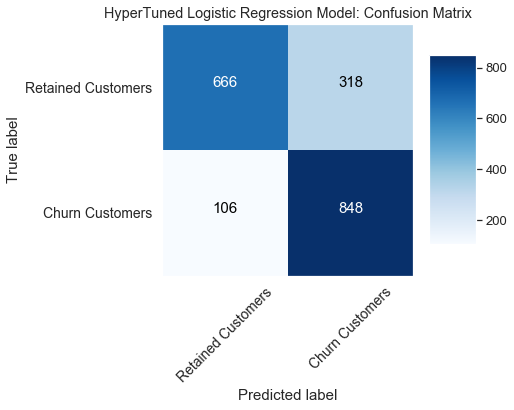

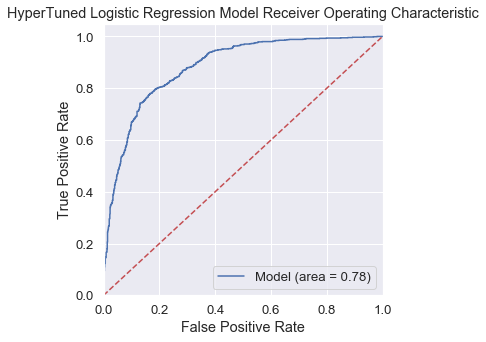

ModelName  AccuracyScore  RecallScore  \
3           Default Random Forest Model       0.835913     0.863732   
4              HyperTuned Random Forest       0.818885     0.861635   
4              HyperTuned Random Forest       0.816821     0.857442   
2  HyperTuned Logistic Regression Model       0.800000     0.888889   
1     Default Logistic Regression Model       0.797730     0.805031   
2  HyperTuned Logistic Regression Model       0.933962     0.933962   
0                        Dummy Baseline       0.737081     0.000000   

   PrecisionScore   F1Score  AreaUnderCurve  
3        0.814229  0.838250        0.836337  
4        0.789625  0.824060        0.819537  
4        0.788814  0.821698        0.817441  
2        0.727273  0.800000        0.782859  
1        0.788501  0.796680        0.797841  
2        0.691770  0.794826        0.765253  
0        0.000000  0.000000        0.500000

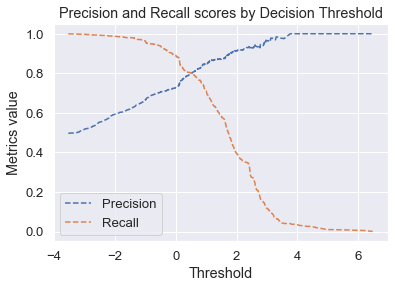

In [122]:
cv_predictions = cv_model.predict(X_test)
model_comparison = model_comparison.append(model_scores(model_name="HyperTuned Logistic Regression Model",
                                     model = cv_model,
                                     Xtest = X_test,
                                     ytest = y_test,
                                     predictions = cv_predictions,
                                     idx = 2),
                       ignore_index = False)

model_comparison = model_comparison.drop_duplicates()
y_score = cv_model.decision_function(X_test)
plot_precision_recall(y_test, y_score)
model_comparison

# Build Random Forest Model with Default Parameters

In [79]:
# Prepare data for split
telecom_y = []
telecom_y = os_data_y["Churn"]
telecom_y = telecom_y.ravel()

#telecom_x = os_data_X[final_cols] # work with only important features
#Use the entire Balanced data set to build Random Forest train/test set. 
#The algorithm will list out most importance features
telecom_x = os_data_X
#telecom_x = telecom_x.drop(columns="tenure", axis=1)

# Split Data
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(telecom_x, 
                                                                telecom_y, 
                                                                test_size= 0.25, 
                                                                random_state=0, 
                                                                shuffle=True)

In [80]:
X_train_rf.head()

gender  SeniorCitizen  Partner  Dependents  PhoneService  MultipleLines  \
2100       1              1        1           0             1              1   
3490       0              0        1           1             1              1   
7444       0              1        0           0             1              0   
4193       1              0        1           1             0              0   
1715       1              0        0           0             0              0   

      OnlineSecurity  OnlineBackup  DeviceProtection  TechSupport  \
2100               0             1                 1            1   
3490               1             0                 1            1   
7444               0             0                 0            0   
4193               0             1                 0            0   
1715               0             0                 0            0   

      StreamingTV  StreamingMovies  PaperlessBilling  InternetService_DSL  \
2100            1                1                 1                    0   
3490            1                1                 1                    1   
7444            0                0                 1                    0   
4193            1                1                 1                    1   
1715            1                0                 1                    1   

      InternetService_FiberOptic  InternetService_No  Contract_1yr  \
2100                           1                   0             0   
3490                           0                   0             0   
7444                           1                   0             0   
4193                           0                   0             1   
1715                           0                   0             0   

      Contract_2yr  Contract_Monthly  PaymentMethod_AutoBankTransfer  \
2100             1                 0                               1   
3490             1                 0                               0   
7444             0                 1                               0   
4193             0                 0                               1   
1715             0                 1                               0   

      PaymentMethod_AutoCreditCard  PaymentMethod_ECheck  \
2100                             0                     0   
3490                             0                     1   
7444                             0                     1   
4193                             0                     0   
1715                             1                     0   

      PaymentMethod_MCheck  tenuregroup_t_0-1  tenuregroup_t_1-2  \
2100                     0                  0                  0   
3490                     0                  0                  0   
7444                     0                  0                  1   
4193                     0                  0                  0   
1715                     0                  1                  0   

      tenuregroup_t_2-4  tenuregroup_t_4-5  tenuregroup_t_5plus  \
2100                  0                  0                    1   
3490                  0                  1                    0   
7444                  0                  0                    0   
4193                  0                  1                    0   
1715                  0                  0                    0   

      MonthlyCharges  TotalCharges  
2100        1.450360      2.222885  
3490        0.656021      1.131928  
7444        0.313396     -0.591187  
4193       -0.430794      0.115376  
1715       -0.999129     -0.875146

In [81]:
# Create the model with 100 trees
rf_model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = "sqrt")
# Fit on training data
rf_model.fit(X_train_rf, y_train_rf)

RandomForestClassifier(max_features='sqrt')

In [82]:
rf_pred = rf_model.predict(X_test_rf)

Top 10 Features from Default Random Forest


feature  importance
29                TotalCharges    0.163582
28              MonthlyCharges    0.159079
18            Contract_Monthly    0.093682
17                Contract_2yr    0.045668
23           tenuregroup_t_0-1    0.043353
14  InternetService_FiberOptic    0.042647
21        PaymentMethod_ECheck    0.035228
6               OnlineSecurity    0.031529
9                  TechSupport    0.029642
0                       gender    0.026603

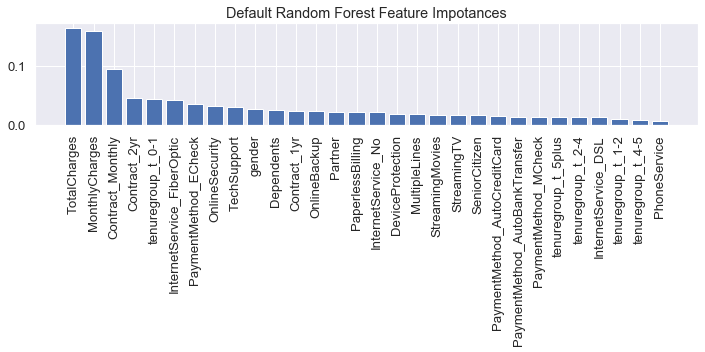

In [89]:
rf_model.feature_importances_
# List Feature Importances
feature_importance = pd.DataFrame({"feature": list(X_train_rf.columns),
                                    "importance":rf_model.feature_importances_}).sort_values("importance", ascending=False)
plt.figure(figsize=(10,5))
plt.bar(x="feature", height="importance", data=feature_importance)
plt.xticks(feature_importance["feature"].tolist(), rotation=90)
plt.title("Default Random Forest Feature Impotances")
plt.tight_layout()

print("Top 10 Features from Default Random Forest")
feature_importance.head(10)

 Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.81      0.83       984
           1       0.81      0.86      0.84       954

    accuracy                           0.84      1938
   macro avg       0.84      0.84      0.84      1938
weighted avg       0.84      0.84      0.84      1938

 Accuracy Score: 
 0.8359133126934984
 Precision: 0.8142292490118577  & Recall Scores: 0.8637316561844863

 F1 Score: 
 0.8382502543234994
 AUC: 
 0.8363373728076904


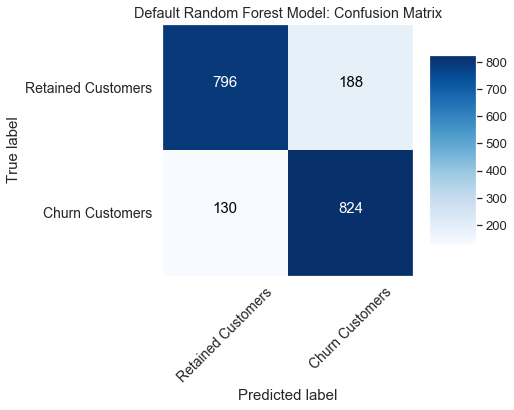

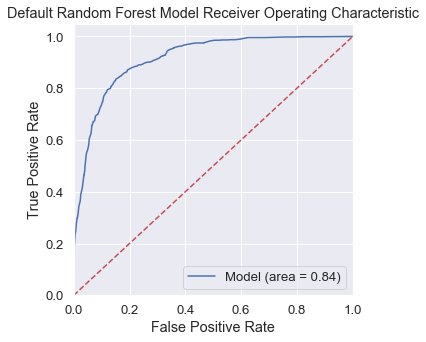

ModelName  AccuracyScore  RecallScore  \
0                        Dummy Baseline       0.737081     0.000000   
1     Default Logistic Regression Model       0.797730     0.805031   
2  HyperTuned Logistic Regression Model       0.933962     0.933962   
3           Default Random Forest Model       0.835913     0.863732   

   PrecisionScore   F1Score  AreaUnderCurve  
0        0.000000  0.000000        0.500000  
1        0.788501  0.796680        0.797841  
2        0.691770  0.794826        0.765253  
3        0.814229  0.838250        0.836337

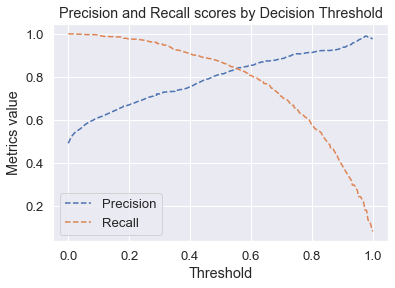

In [90]:
#model_comparison = model_comparison.drop(index=3, axis=0)
model_comparison = model_comparison.append(model_scores(model_name="Default Random Forest Model",
                                                           model = rf_model,
                                                           Xtest = X_test_rf,
                                                           ytest = y_test_rf,
                                                           predictions = rf_pred,
                                                           idx = 3),
                                          ignore_index = False)
model_comparison = model_comparison.drop_duplicates()

y_pred_proba = rf_model.predict_proba(X_test_rf)
plot_precision_recall(y_test_rf, y_pred_proba[:,1])

model_comparison

### Hyperparameter tuning for Random Forest Model

In [112]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
#    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [50, 100, 200, 300, 1000], 
    'max_features': ["sqrt", "log2"]
}

# Instantiate the grid search model
cv_rf_model = GridSearchCV(estimator = rf_model, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring="f1") # 3-fold validation

#Add , scoring="recall" above later on

In [113]:
# Train the best model; Takes around 10 mins! - Get some coffee :)
cv_rf_model.fit(X_train_rf, y_train_rf)
print("Best Parameters:", cv_rf_model.best_params_)
print(f"Best Score after Random Forest HPO: {cv_rf_model.best_score_} \n")
print(f"Best Model Accuracy Score after RF HPO: {cv_rf_model.score(X_test_rf, y_test_rf)}")

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  5.9min finished


Best Parameters: {'bootstrap': True, 'max_depth': 110, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}
Best Score after Random Forest HPO: 0.8313322151459545 

Best Model Accuracy Score after RF HPO: 0.8216976393771974


 Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.78      0.81       984
           1       0.79      0.86      0.82       954

    accuracy                           0.82      1938
   macro avg       0.82      0.82      0.82      1938
weighted avg       0.82      0.82      0.82      1938

 Accuracy Score: 
 0.8168214654282766
 Precision: 0.7888138862102217  & Recall Scores: 0.8574423480083857

 F1 Score: 
 0.8216976393771974
 AUC: 
 0.8174406861993149


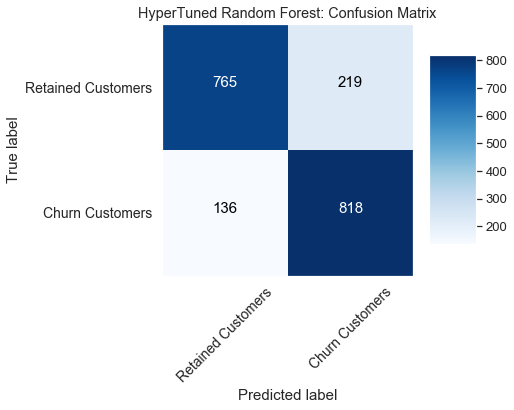

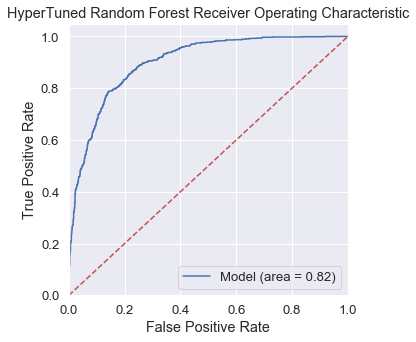

ModelName  AccuracyScore  RecallScore  \
2  HyperTuned Logistic Regression Model       0.933962     0.933962   
3           Default Random Forest Model       0.835913     0.863732   
4              HyperTuned Random Forest       0.818885     0.861635   
1     Default Logistic Regression Model       0.797730     0.805031   
0                        Dummy Baseline       0.737081     0.000000   
2  HyperTuned Logistic Regression Model       0.800000     0.888889   
4              HyperTuned Random Forest       0.816821     0.857442   

   PrecisionScore   F1Score  AreaUnderCurve  
2        0.691770  0.794826        0.765253  
3        0.814229  0.838250        0.836337  
4        0.789625  0.824060        0.819537  
1        0.788501  0.796680        0.797841  
0        0.000000  0.000000        0.500000  
2        0.727273  0.800000        0.782859  
4        0.788814  0.821698        0.817441

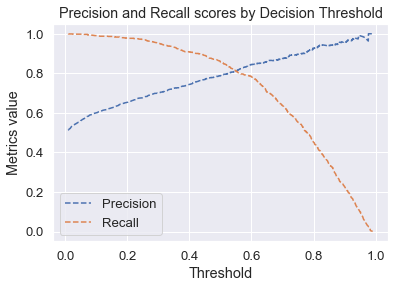

In [114]:
#model_comparison = model_comparison.drop(index=4, axis=0)
best_rf_model = cv_rf_model.best_estimator_
cv_rf_pred = best_rf_model.predict(X_test_rf)

model_comparison = model_comparison.append(model_scores(model_name="HyperTuned Random Forest",
                                                        model = best_rf_model,
                                                        Xtest = X_test_rf,
                                                        ytest = y_test_rf,
                                                        predictions = cv_rf_pred,
                                                        idx = 4), 
                                           ignore_index = False)

model_comparison = model_comparison.drop_duplicates()

y_pred_proba = best_rf_model.predict_proba(X_test_rf)
plot_precision_recall(y_test_rf, y_pred_proba[:,1])
model_comparison

feature  importance
29                TotalCharges    0.137480
18            Contract_Monthly    0.127488
28              MonthlyCharges    0.118755
17                Contract_2yr    0.063330
14  InternetService_FiberOptic    0.058567
21        PaymentMethod_ECheck    0.048614
23           tenuregroup_t_0-1    0.047093
6               OnlineSecurity    0.039994
9                  TechSupport    0.031547
16                Contract_1yr    0.030715

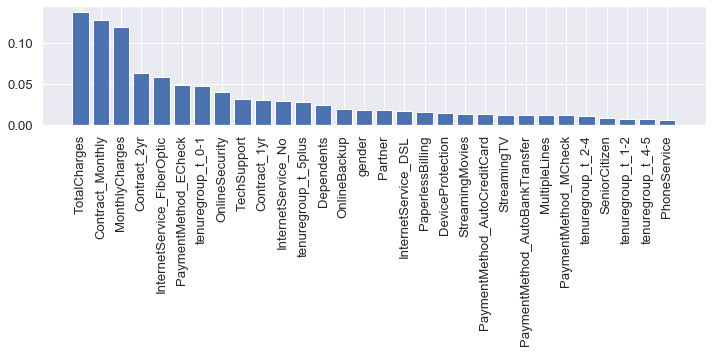

In [115]:
# List Feature Importances
feature_importance = pd.DataFrame({"feature": list(X_train_rf.columns),
                                    "importance":best_rf_model.feature_importances_}).sort_values("importance", ascending=False)
plt.figure(figsize=(10,5))
plt.bar(x="feature", height="importance", data=feature_importance)
plt.xticks(feature_importance["feature"].tolist(), rotation=90)
plt.tight_layout()

feature_importance.head(10)

In [116]:
# Pull out one tree from the Default Random Forest for visualization
est_tree = rf_model.estimators_[5]

graph = Source(tree.export_graphviz(est_tree,out_file=None,
                                        rounded=True,proportion = False,
                                        feature_names = X_train_rf.columns.tolist(), 
                                        precision  = 2,
                                        class_names=["Not churn","Churn"],
                                        filled = True                         
                                       )
                  )
#SVG(graph.pipe(format='svg'))
png_bytes = graph.pipe(format='png')
with open('dtree_pipe.png','wb') as f:
    f.write(png_bytes)

from IPython.display import Image
Image(png_bytes)

display(graph)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.413955 to fit


In [118]:
model_comparison = model_comparison.sort_values(by=["F1Score", "RecallScore", "AccuracyScore",], ascending=False) 
model_comparison
#Recall scores are generally more focused than Precision Scores, to reduce false negatives on customers churning.

ModelName  AccuracyScore  RecallScore  \
3           Default Random Forest Model       0.835913     0.863732   
4              HyperTuned Random Forest       0.818885     0.861635   
4              HyperTuned Random Forest       0.816821     0.857442   
2  HyperTuned Logistic Regression Model       0.800000     0.888889   
1     Default Logistic Regression Model       0.797730     0.805031   
2  HyperTuned Logistic Regression Model       0.933962     0.933962   
0                        Dummy Baseline       0.737081     0.000000   

   PrecisionScore   F1Score  AreaUnderCurve  
3        0.814229  0.838250        0.836337  
4        0.789625  0.824060        0.819537  
4        0.788814  0.821698        0.817441  
2        0.727273  0.800000        0.782859  
1        0.788501  0.796680        0.797841  
2        0.691770  0.794826        0.765253  
0        0.000000  0.000000        0.500000

# Final Conclusions on Models:

In [120]:
best_df = pd.DataFrame(columns=["PerfParam", "BestParamVal", "Model"])

best_recall_score = model_comparison["RecallScore"].max()
best_recall_score_model = model_comparison[model_comparison["RecallScore"]==best_recall_score]["ModelName"].tolist()
best_df = best_df.append([{"PerfParam":"RecallScore", 
                           "BestParamVal":best_recall_score, 
                           "Model":best_recall_score_model[0]}], 
                         ignore_index=True)

best_f1_score = model_comparison["F1Score"].max()
best_f1_score_model = model_comparison[model_comparison["F1Score"]==best_f1_score]["ModelName"].tolist()
best_df = best_df.append([{"PerfParam":"F1Score", 
                           "BestParamVal":best_f1_score, 
                           "Model":best_f1_score_model[0]}], 
                         ignore_index=True)

best_accuracy_score = model_comparison["AccuracyScore"].max()
best_accuracy_score_model = model_comparison[model_comparison["AccuracyScore"]==best_accuracy_score]["ModelName"].tolist()
best_df = best_df.append([{"PerfParam":"AccuracyScore", 
                           "BestParamVal":best_accuracy_score, 
                           "Model":best_accuracy_score_model[0]}], 
                         ignore_index=True)

best_auc_score = model_comparison["AreaUnderCurve"].max()
best_auc_score_model = model_comparison[model_comparison["AreaUnderCurve"]==best_auc_score]["ModelName"].tolist()
best_df = best_df.append([{"PerfParam":"AreaUnderCurve", 
                           "BestParamVal":best_auc_score, 
                           "Model":best_auc_score_model[0]}], 
                         ignore_index=True)

best_precision_score = model_comparison["PrecisionScore"].max()
best_precision_score_model = model_comparison[model_comparison["PrecisionScore"]==best_precision_score]["ModelName"].tolist()
best_df = best_df.append([{"PerfParam":"PrecisionScore", 
                           "BestParamVal":best_precision_score, 
                           "Model":best_precision_score_model[0]}], 
                         ignore_index=True)


print("\033[1mFinal Model Performance Assessments: \033[0;0m")
print(f"Best Recall score is for \033[1m {best_recall_score_model[0]}\033[0;0m with \033[1m{best_recall_score :.2%}\033[0;0m")
print(f"Best F1 score is for \033[1m{best_f1_score_model[0]}\033[0;0m with \033[1m{best_f1_score :.2%}\033[0;0m")
print(f"Best accuracy score is for \033[1m{best_accuracy_score_model[0]}\033[0;0m with \033[1m{best_accuracy_score :.2%}\033[0;0m")
print(f"Best AUC score is for \033[1m {best_auc_score_model[0]}\033[0;0m with \033[1m{best_auc_score :.2%}\033[0;0m")
print(f"Best Precision score is for \033[1m {best_precision_score_model[0]}\033[0;0m with \033[1m{best_precision_score :.2%}\033[0;0m")

best_df

Final Model Performance Assessments: 
Best Recall score is for  HyperTuned Logistic Regression Model with 93.40%
Best F1 score is for Default Random Forest Model with 83.83%
Best accuracy score is for HyperTuned Logistic Regression Model with 93.40%
Best AUC score is for  Default Random Forest Model with 83.63%
Best Precision score is for  Default Random Forest Model with 81.42%


PerfParam  BestParamVal                                 Model
0     RecallScore      0.933962  HyperTuned Logistic Regression Model
1         F1Score      0.838250           Default Random Forest Model
2   AccuracyScore      0.933962  HyperTuned Logistic Regression Model
3  AreaUnderCurve      0.836337           Default Random Forest Model
4  PrecisionScore      0.814229           Default Random Forest Model

Percentage of Retained Customers from Test- Random Forest: 47.78%
Percentage of Churn Customers from Test: 52.22%
Count of Retained Customers from Test- Random Forest: 926 out of 1938
Count of Churned Customers from Test- Random Forest: 1012 out of 1938
Percentage of Retained Customers from Test from LR: 39.83%
Percentage of Churn Customers from Test: 60.17%
Count of Retained Customers from Test- LR: 772 out of 1938
Count of Churned Customers from Test- LR: 1166 out of 1938


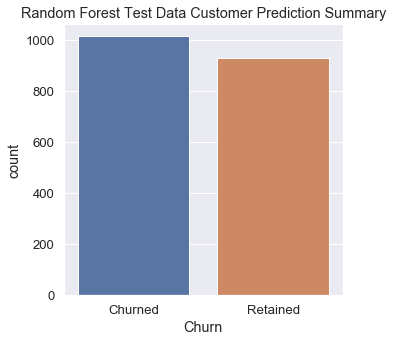

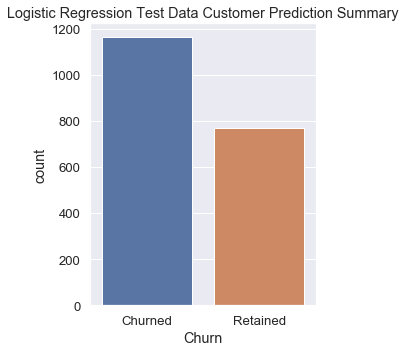

In [124]:
#Random Forest

final_outputs = pd.DataFrame({"Churn":rf_pred})
final_outputs = final_outputs.replace({0:"Retained", 1:"Churned"})

plt.figure(figsize=(5,5))
sns.countplot(data=final_outputs, x="Churn")
count_no = len(final_outputs[final_outputs["Churn"]=="Retained"])
count_yes = len(final_outputs[final_outputs["Churn"]=="Churned"])
print(f"Percentage of Retained Customers from Test- Random Forest: {count_no/(count_no+count_yes) :.2%}")
print(f"Percentage of Churn Customers from Test: {count_yes/(count_no+count_yes) :.2%}")
print(f"Count of Retained Customers from Test- Random Forest: {count_no} out of {count_no+count_yes}")
print(f"Count of Churned Customers from Test- Random Forest: {count_yes} out of {count_no+count_yes}")
plt.title("Random Forest Test Data Customer Prediction Summary")


# Logistic Regression
final_outputs = pd.DataFrame({"Churn":cv_predictions})
final_outputs = final_outputs.replace({0:"Retained", 1:"Churned"})
plt.figure(figsize=(5,5))
sns.countplot(data=final_outputs, x="Churn")
count_no = len(final_outputs[final_outputs["Churn"]=="Retained"])
count_yes = len(final_outputs[final_outputs["Churn"]=="Churned"])

print(f"Percentage of Retained Customers from Test from LR: {count_no/(count_no+count_yes) :.2%}")
print(f"Percentage of Churn Customers from Test: {count_yes/(count_no+count_yes) :.2%}")
print(f"Count of Retained Customers from Test- LR: {count_no} out of {count_no+count_yes}")
print(f"Count of Churned Customers from Test- LR: {count_yes} out of {count_no+count_yes}")
plt.title("Logistic Regression Test Data Customer Prediction Summary")
plt.tight_layout()

In [168]:
## Obs: Based on 


NameError: name 'python' is not defined